# Imports

In [1]:
import os

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

import catboost
import xgboost

In [2]:
import sklearn
from sklearn import set_config

In [3]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.4.1.post1


In [4]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [5]:
set_config(transform_output="pandas")

In [6]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [7]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [8]:
# the CWD in Kaggle is this path
# /kaggle/working

In [9]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [10]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.ipynb_checkpoints',
 'Benchmark_20240328.ipynb',
 'Benchmark_20240329.ipynb',
 'Benchmark_20240330.ipynb',
 'Benchmark_20240331.ipynb',
 'Benchmark_20240401.ipynb',
 'catboost_info',
 'input',
 'outputs',
 'requirements.txt',
 'requirements_py310.txt',
 'venvs',
 'videos']

# Helper functions

In [11]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading & EDA

In [12]:
X, _ = load_data()

In [13]:
nulls_per_row = X.isnull()

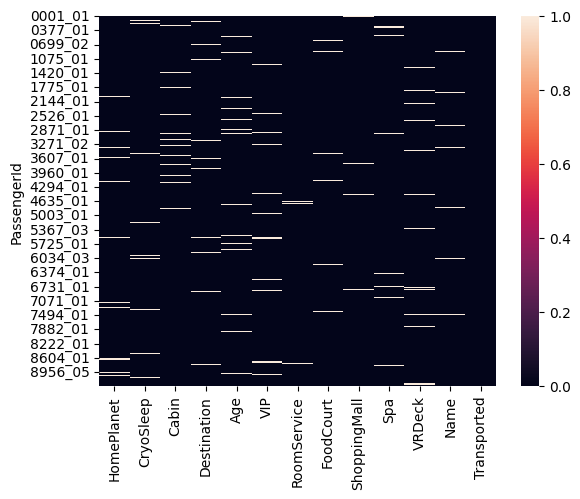

In [14]:
sns.heatmap(nulls_per_row);

In [15]:
def bucketize_age(age):
    
    if 0 <= age < 10:
        return "[0-10)"
    
    elif 10 <= age < 20:
        return "[10-20)"
    
    elif 20 <= age < 30:
        return "[20-30)"
    
    elif 30 <= age < 40:
        return "[30-40)"
    
    elif 40 <= age < 50:
        return "[40-50)"
    
    elif 50 <= age < 60:
        return "[50-60)" 
    
    elif 60 <= age < 70:
        return "[60-70)"
    
    elif age >= 70:
        return "[70 - inf"

In [16]:
Xc = X.copy(deep=True).dropna()

In [17]:
Xc["AgeBuketized"] = Xc["Age"].apply(bucketize_age)

Xc["AgeKBinsDiscretized"] = KBinsDiscretizer(
    encode = "ordinal",
    strategy = "uniform",
    n_bins = 8
).fit_transform(Xc[["Age"]].dropna())

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [18]:
Xc[["AgeKBinsDiscretized", "AgeBuketized"]].drop_duplicates().sort_values("AgeKBinsDiscretized")

,AgeKBinsDiscretized,AgeBuketized
PassengerId,,
0017_01,0.0,[0-10)
0004_01,1.0,[10-20)
0002_01,2.0,[20-30)
0001_01,3.0,[30-40)
0005_01,4.0,[40-50)
0003_01,5.0,[50-60)
0062_01,6.0,[60-70)
0378_03,7.0,[70 - inf


In [19]:
(
    Xc
    .pivot_table(
        index = "AgeBuketized",
        columns = "AgeKBinsDiscretized",
        values = "Age",
        aggfunc = len,
        margins = True,
        fill_value = 0
    )
)

AgeKBinsDiscretized,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
AgeBuketized,,,,,,,,,
[0-10),532,0,0,0,0,0,0,0,532
[10-20),0,1138,0,0,0,0,0,0,1138
[20-30),0,0,2131,0,0,0,0,0,2131
[30-40),0,0,0,1358,0,0,0,0,1358
[40-50),0,0,0,0,812,0,0,0,812
[50-60),0,0,0,0,0,438,0,0,438
[60-70),0,0,0,0,0,0,161,0,161
[70 - inf,0,0,0,0,0,0,0,36,36
All,532,1138,2131,1358,812,438,161,36,6606


In [20]:
Xc[["AgeKBinsDiscretized", "AgeBuketized", "Age"]].drop_duplicates().sort_values("Age")

,AgeKBinsDiscretized,AgeBuketized,Age
PassengerId,,,
0017_01,0.0,[0-10),0.0
0020_01,0.0,[0-10),1.0
0031_02,0.0,[0-10),2.0
0092_03,0.0,[0-10),3.0
0044_02,0.0,[0-10),4.0
...,...,...,...
1222_01,7.0,[70 - inf,75.0
1455_05,7.0,[70 - inf,76.0
3176_01,7.0,[70 - inf,77.0


In [21]:
r_ = (
    Xc
    .groupby("AgeBuketized")
    .agg(
        nr = ("CryoSleep", len),
        mean_transported = ("Transported", np.mean)
    )
    .reset_index()
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/125699061.py:2: FutureWarning: The provided callable <function mean at 0x10704be20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  Xc


In [22]:
r_

,AgeBuketized,nr,mean_transported
0,[0-10),532,0.721805
1,[10-20),1138,0.534271
2,[20-30),2131,0.474894
3,[30-40),1358,0.443299
4,[40-50),812,0.502463
5,[50-60),438,0.495434
6,[60-70),161,0.503106
7,[70 - inf,36,0.416667


In [23]:
#5F5D9C
#6196A6
#A4CE95
#F4EDCC

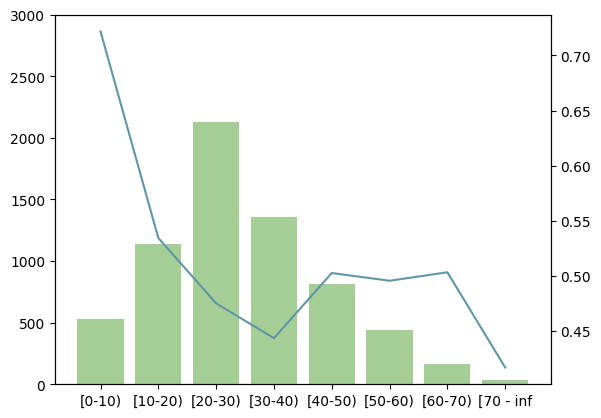

In [24]:
fig = plt.figure()
ax = fig.subplots()

ax.bar(x = r_["AgeBuketized"], height = r_["nr"], color = "#A4CE95")

ax.set_ylim(bottom=0, top=3000)

ax2 = ax.twinx()

ax2.plot(r_["mean_transported"], color = "#6196A6");

In [25]:
(X.isnull().sum(axis = 1) == X.shape[1]).sum()

0

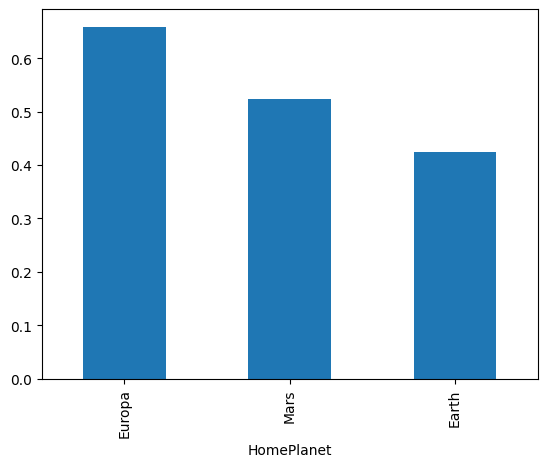

In [26]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [27]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [28]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
);

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/3554285840.py:2: FutureWarning: The provided callable <function mean at 0x10704be20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


In [29]:
_

nr_rows  transported_ratio  nr_rows_pct
HomePlanet CryoSleep                                         
Earth      False         3106              32.10        37.53
           True          1382              65.63        16.70
Europa     False         1162              40.02        14.04
           True           911              98.90        11.01
Mars       False         1047              27.70        12.65
           True           669              91.18         8.08

In [30]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [31]:
X.groupby(["LenCabin"]).size()

LenCabin
3     199
5     130
6    1201
7    5043
8    2120
dtype: int64

In [32]:
X[X["LenCabin"] == 5].head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5


In [33]:
X["Cabin"].fillna("NA", inplace = True)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/3468940878.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Cabin"].fillna("NA", inplace = True)


In [34]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)
X["CabinLastLetter"] = X["Cabin"].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin)

In [35]:
X["CabinFirstLetter"].value_counts().sort_index()

CabinFirstLetter
A      256
B      779
C      747
D      478
E      876
F     2794
G     2559
NA     199
T        5
Name: count, dtype: int64

In [36]:
X["CabinLastLetter"].value_counts().sort_index()

CabinLastLetter
NA     199
P     4206
S     4288
Name: count, dtype: int64

In [37]:
X["Cabin"].sample(10)

PassengerId
8616_02    F/1767/P
3895_02     E/233/P
3691_01     F/763/P
7249_02    F/1397/S
2524_01      D/74/P
1243_02       A/9/P
8238_02    G/1328/S
7019_01    F/1457/P
2456_01     G/399/P
7289_01      A/78/P
Name: Cabin, dtype: object

In [38]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinFirstLetter
A     0.496094
B     0.734275
C     0.680054
D     0.433054
E     0.357306
F     0.439871
G     0.516217
NA    0.502513
T     0.200000
Name: Transported, dtype: float64

In [39]:
(
    X
    .groupby(["CabinLastLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

CabinLastLetter
NA    0.502513
P     0.451260
S     0.555037
Name: Transported, dtype: float64

In [40]:
pd.concat([
    (
        X
        .groupby(["CabinFirstLetter", "CabinLastLetter"])
        ["Transported"]
        .mean()
        .sort_index()
        .unstack()
    ),
    (
        X
        .groupby(["CabinFirstLetter"])
        ["Transported"]
        .mean()
        .sort_index()
    )], axis = 1)

,NA,P,S,Transported
CabinFirstLetter,,,,
A,NaN,0.435897,0.546763,0.496094
B,NaN,0.674221,0.784038,0.734275
C,NaN,0.580645,0.763547,0.680054
D,NaN,0.403226,0.465217,0.433054
E,NaN,0.342657,0.371365,0.357306
F,NaN,0.410987,0.470501,0.439871
G,NaN,0.448276,0.583788,0.516217
NA,0.502513,NaN,NaN,0.502513
T,NaN,0.250000,0.000000,0.200000


In [41]:
X.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,LenCabin
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,6.984240
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.898869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,7.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000


In [42]:
X.isnull().sum()

HomePlanet          201
CryoSleep           217
Cabin                 0
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
Transported           0
LenCabin              0
CabinFirstLetter      0
CabinLastLetter       0
dtype: int64

In [43]:
X.shape

(8693, 16)

In [44]:
(
    X
    .pivot_table(
        index = "HomePlanet",
        columns = "Destination",
        values = "Transported",
        aggfunc = [len, np.mean],
        margins = True
    )
)

/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x10704be20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x10704be20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X
/var/folders/m8/pkh7yz5j3_318g64strn1y680000gn/T/ipykernel_9366/4213924544.py:2: FutureWarning: The provided callable <function mean at 0x10704be20> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X


len                                        mean  \
Destination 55 Cancri e PSO J318.5-22 TRAPPIST-1e   All 55 Cancri e   
HomePlanet                                                            
Earth               690           712        3101  4503    0.504348   
Europa              886            19        1189  2094    0.689616   
Mars                193            49        1475  1717    0.611399   
All                1769           780        5765  8314    0.608819   

                                                 
Destination PSO J318.5-22 TRAPPIST-1e       All  
HomePlanet                                       
Earth            0.498596    0.389229  0.424162  
Europa           0.736842    0.634987  0.659026  
Mars             0.448980    0.511864  0.521258  
All              0.501282    0.471292  0.503368

In [45]:
X["Name"].fillna("NA").apply(lambda name: len(name.split(" "))).value_counts()

Name
2    8493
1     200
Name: count, dtype: int64

In [46]:
X.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,LenCabin,CabinFirstLetter,CabinLastLetter
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,5,B,P
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5,F,S
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5,A,S
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5,A,S
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5,F,S


In [47]:
X["Surname"] = X["Name"].fillna("NA").apply(lambda name: name.split(" ")[1] if name != "NA" else name)

In [48]:
X["Surname"]

PassengerId
0001_01      Ofracculy
0002_01          Vines
0003_01         Susent
0003_02         Susent
0004_01    Santantines
              ...     
9276_01      Noxnuther
9278_01      Mondalley
9279_01         Connon
9280_01      Hontichre
9280_02      Hontichre
Name: Surname, Length: 8693, dtype: object

In [49]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
)

Surname
Acobson        0.250000
Acobsond       0.333333
Adavisons      0.444444
Adkinson       0.000000
Admingried     0.750000
                 ...   
Wynneyerson    0.500000
Yanton         0.285714
Yatters        0.500000
Yorkland       0.636364
Youngrayes     0.333333
Name: Transported, Length: 2218, dtype: float64

In [50]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
    .value_counts(normalize=True)
    .sort_index()
)

Transported
0.000000    0.165915
0.111111    0.000902
0.125000    0.002254
0.142857    0.002705
0.166667    0.009468
0.200000    0.019387
0.222222    0.000451
0.230769    0.000451
0.250000    0.037421
0.266667    0.000451
0.272727    0.001353
0.285714    0.010821
0.300000    0.001353
0.307692    0.000451
0.333333    0.076646
0.357143    0.000451
0.363636    0.001353
0.375000    0.009017
0.384615    0.000451
0.388889    0.000451
0.400000    0.033814
0.416667    0.000451
0.428571    0.015329
0.444444    0.003607
0.454545    0.003156
0.461538    0.000451
0.500000    0.168170
0.505000    0.000451
0.545455    0.001353
0.555556    0.004959
0.571429    0.012624
0.583333    0.001353
0.600000    0.034265
0.615385    0.000451
0.625000    0.004058
0.636364    0.003156
0.642857    0.000451
0.666667    0.080703
0.700000    0.000902
0.714286    0.009017
0.727273    0.000902
0.750000    0.040126
0.769231    0.000451
0.777778    0.001353
0.800000    0.021641
0.833333    0.009017
0.857143    0.002705
0

In [51]:
del X, _

# Preprocessing and Modelling

In [52]:
X_train, X_test = load_data()

In [53]:
y = X_train.pop("Transported")

In [54]:
class DebuggerTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("DummyTransformer")
        return X

In [55]:
class CabinLetterExtractor(BaseEstimator, TransformerMixin):
    
    
    def __init__(self, letter:Union["first", "last"], verbose:bool=False):
        
        self.__assert_letter(letter=letter)
        
        self.letter = letter
        self.verbose = verbose
        
    def __assert_letter(self, letter):
        
        assert_message = "Valid letters are `first` or `last`."
        assert_message += f"You have passed {letter}"
        
        assert letter in ["first", "last"], assert_message
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        if self.verbose:
            print("CabinLetterExtractor")
            print(type(X))
            
        if self.letter == "first":
            return X.iloc[:, 0].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin).to_frame()
        else:
            return X.iloc[:, 0].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin).to_frame()

In [56]:
ct_impute = ColumnTransformer(
    transformers = [
        ("impute_numerical", SimpleImputer(strategy="mean"), make_column_selector(dtype_include=np.number)),
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'drop'
)

In [57]:
ct_impute

ColumnTransformer(transformers=[('impute_numerical', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17f06be80>),
                                ('impute_cabin',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['Cabin']),
                                ('impute_categorical',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Name'])])

In [58]:
Xt = ct_impute.fit_transform(X_train)

In [59]:
Xt.shape

(8693, 12)

In [60]:
Xt.head()

,impute_numerical__Age,impute_numerical__RoomService,impute_numerical__FoodCourt,impute_numerical__ShoppingMall,impute_numerical__Spa,impute_numerical__VRDeck,impute_cabin__Cabin,impute_categorical__HomePlanet,impute_categorical__CryoSleep,impute_categorical__Destination,impute_categorical__VIP,impute_categorical__Name
PassengerId,,,,,,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,B/0/P,Europa,False,TRAPPIST-1e,False,Maham Ofracculy
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,F/0/S,Earth,False,TRAPPIST-1e,False,Juanna Vines
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,A/0/S,Europa,False,TRAPPIST-1e,True,Altark Susent
0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,A/0/S,Europa,False,TRAPPIST-1e,False,Solam Susent
0004_01,16.0,303.0,70.0,151.0,565.0,2.0,F/1/S,Earth,False,TRAPPIST-1e,False,Willy Santantines


In [61]:
class SurnameExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose:bool=False):
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.iloc[:, 0].apply(lambda name: name.split(" ")[1] if name != "NA" else name).to_frame()

TO DO: define an EmbeddingTransfomer compatible with scikit-learn

https://medium.com/@micahmelling/categorical-embeddings-in-scikit-learn-pipeline-c81071be5140

In [62]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_buckets", KBinsDiscretizer(encode = "ordinal", strategy = "uniform", n_bins = 8)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [63]:
fu_cabin = FeatureUnion(
    transformer_list = [
        ("extract_first_letter", CabinLetterExtractor(letter="first")),
        ("extract_last_letter", CabinLetterExtractor(letter="last"))
    ]
)

In [64]:
fe_cabin = Pipeline(
    steps = [
        ("extract_letters_from_cabin", fu_cabin),
        ("ohe_first_letter", OneHotEncoder(sparse_output=False)),
    ]
)

In [65]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, list_surnames):
        self.list_surnames = list_surnames
        self.oe = OrdinalEncoder()
        
        
    def fit(self, X, y=None):
        
        self.oe.fit(self.list_surnames)
        
        return self
    
    def transform(self, X, y=None):
        Xt = self.oe.transform(X)
        return Xt

In [66]:
# We are getting all the surnames that exist in train and test
# because our CustomOrdinalEncoder can faill when doing CV
# or when predicting test
surnames_ = pd.concat([X_train[["Name"]], X_test[["Name"]]]).dropna()

In [67]:
SURNAMES = SurnameExtractor().fit_transform(surnames_).values

In [68]:
fe_surname = Pipeline(
    steps = [
        ("extract_surname", SurnameExtractor()),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(list_surnames=SURNAMES))
    ]
)

In [69]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("pass", "passthrough", [1, 2, 3, 4, 5]),
        ("fe_cabin", fe_cabin, ["impute_cabin__Cabin"]),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        ),
        ("oe", OrdinalEncoder(), ["impute_categorical__Destination"]),
        ("surname", fe_surname, ["impute_categorical__Name"])
    ],
    remainder = "passthrough"
)

In [70]:
ct_fe

ColumnTransformer(remainder='passthrough',
                  transformers=[('fu_age',
                                 FeatureUnion(transformer_list=[('fe_age_12',
                                                                 Binarizer(threshold=12)),
                                                                ('fe_age_18',
                                                                 Binarizer(threshold=18)),
                                                                ('fe_age_buckets',
                                                                 KBinsDiscretizer(encode='ordinal',
                                                                                  n_bins=8,
                                                                                  strategy='uniform')),
                                                                ('fe_age_pass',
                                                                 'passthrough')]),
                                 ['impute_numerical__Age']),
                                ('pass', 'passthrough', [1, 2, 3, 4, 5]),
                                (...
                                  'impute_categorical__CryoSleep',
                                  'impute_categorical__VIP']),
                                ('oe', OrdinalEncoder(),
                                 ['impute_categorical__Destination']),
                                ('surname',
                                 Pipeline(steps=[('extract_surname',
                                                  SurnameExtractor()),
                                                 ('custom_ordinal_encoder',
                                                  CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                 ['impute_categorical__Name'])])

In [71]:
def drop_duplicated_columns(X):
    return X.iloc[:, ~X.columns.duplicated()]

In [72]:
pipe = Pipeline(
    steps = [
        ("impute", ct_impute),
        ("fe", ct_fe),
        ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
        # ("model", HistGradientBoostingClassifier())
        ("model", catboost.CatBoostClassifier())
        # ("model", xgboost.XGBClassifier())
    ]
)

In [73]:
pipe

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f06be80>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destinatio...
                                                                  ('custom_ordinal_encoder',
                                                                   CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                  ['impute_categorical__Name'])])),
                ('drop_duplicated_columns',
                 FunctionTransformer(func=<function drop_duplicated_columns at 0x3012af130>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x3012a0880>)])

In [74]:
X_train_ = pipe[:3].fit_transform(X_train)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [75]:
y.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [76]:
cv_scores = cross_val_score(estimator=pipe, X=X_train, y=y, cv=10)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024797
0:	learn: 0.6817674	total: 58.1ms	remaining: 58s
1:	learn: 0.6716167	total: 60.8ms	remaining: 30.3s
2:	learn: 0.6604628	total: 66.1ms	remaining: 22s
3:	learn: 0.6499815	total: 72.1ms	remaining: 18s
4:	learn: 0.6400668	total: 77.5ms	remaining: 15.4s
5:	learn: 0.6314268	total: 82.1ms	remaining: 13.6s
6:	learn: 0.6223388	total: 85.1ms	remaining: 12.1s
7:	learn: 0.6132205	total: 89.8ms	remaining: 11.1s
8:	learn: 0.6059522	total: 92.7ms	remaining: 10.2s
9:	learn: 0.5984879	total: 95.3ms	remaining: 9.44s
10:	learn: 0.5917552	total: 97.9ms	remaining: 8.8s
11:	learn: 0.5861564	total: 101ms	remaining: 8.29s
12:	learn: 0.5791167	total: 103ms	remaining: 7.85s
13:	learn: 0.5735360	total: 106ms	remaining: 7.45s
14:	learn: 0.5684385	total: 108ms	remaining: 7.12s
15:	learn: 0.5631631	total: 111ms	remaining: 6.82s
16:	learn: 0.5583982	total: 113ms	remaining: 6.55s
17:	learn: 0.5549981	total: 115ms	remaining: 6.3s
18:	learn: 0.5506914	total: 118ms	remaining: 6.09s
19:	lear

197:	learn: 0.3963060	total: 590ms	remaining: 2.39s
198:	learn: 0.3961646	total: 593ms	remaining: 2.39s
199:	learn: 0.3958387	total: 595ms	remaining: 2.38s
200:	learn: 0.3955957	total: 598ms	remaining: 2.38s
201:	learn: 0.3954585	total: 600ms	remaining: 2.37s
202:	learn: 0.3952398	total: 602ms	remaining: 2.36s
203:	learn: 0.3951137	total: 605ms	remaining: 2.36s
204:	learn: 0.3949397	total: 607ms	remaining: 2.35s
205:	learn: 0.3948159	total: 610ms	remaining: 2.35s
206:	learn: 0.3946859	total: 613ms	remaining: 2.35s
207:	learn: 0.3943511	total: 616ms	remaining: 2.35s
208:	learn: 0.3941437	total: 619ms	remaining: 2.34s
209:	learn: 0.3938947	total: 622ms	remaining: 2.34s
210:	learn: 0.3936647	total: 625ms	remaining: 2.34s
211:	learn: 0.3935169	total: 628ms	remaining: 2.33s
212:	learn: 0.3933767	total: 630ms	remaining: 2.33s
213:	learn: 0.3929841	total: 634ms	remaining: 2.33s
214:	learn: 0.3928267	total: 636ms	remaining: 2.32s
215:	learn: 0.3925560	total: 639ms	remaining: 2.32s
216:	learn: 

417:	learn: 0.3649204	total: 1.18s	remaining: 1.64s
418:	learn: 0.3648305	total: 1.18s	remaining: 1.64s
419:	learn: 0.3646907	total: 1.19s	remaining: 1.64s
420:	learn: 0.3645349	total: 1.19s	remaining: 1.63s
421:	learn: 0.3643822	total: 1.19s	remaining: 1.63s
422:	learn: 0.3642191	total: 1.19s	remaining: 1.63s
423:	learn: 0.3640707	total: 1.2s	remaining: 1.63s
424:	learn: 0.3639693	total: 1.2s	remaining: 1.62s
425:	learn: 0.3638743	total: 1.2s	remaining: 1.62s
426:	learn: 0.3637648	total: 1.2s	remaining: 1.62s
427:	learn: 0.3636575	total: 1.21s	remaining: 1.61s
428:	learn: 0.3635095	total: 1.21s	remaining: 1.61s
429:	learn: 0.3634198	total: 1.21s	remaining: 1.61s
430:	learn: 0.3632882	total: 1.22s	remaining: 1.6s
431:	learn: 0.3631254	total: 1.22s	remaining: 1.6s
432:	learn: 0.3630365	total: 1.22s	remaining: 1.6s
433:	learn: 0.3629046	total: 1.22s	remaining: 1.6s
434:	learn: 0.3627722	total: 1.23s	remaining: 1.59s
435:	learn: 0.3626277	total: 1.23s	remaining: 1.59s
436:	learn: 0.362478

636:	learn: 0.3396690	total: 1.77s	remaining: 1.01s
637:	learn: 0.3395884	total: 1.77s	remaining: 1s
638:	learn: 0.3394559	total: 1.77s	remaining: 1s
639:	learn: 0.3393162	total: 1.77s	remaining: 998ms
640:	learn: 0.3391899	total: 1.78s	remaining: 995ms
641:	learn: 0.3389936	total: 1.78s	remaining: 992ms
642:	learn: 0.3388767	total: 1.78s	remaining: 990ms
643:	learn: 0.3387845	total: 1.78s	remaining: 987ms
644:	learn: 0.3387004	total: 1.79s	remaining: 984ms
645:	learn: 0.3386314	total: 1.79s	remaining: 980ms
646:	learn: 0.3385392	total: 1.79s	remaining: 978ms
647:	learn: 0.3384825	total: 1.79s	remaining: 975ms
648:	learn: 0.3383966	total: 1.8s	remaining: 972ms
649:	learn: 0.3382783	total: 1.8s	remaining: 969ms
650:	learn: 0.3382069	total: 1.8s	remaining: 966ms
651:	learn: 0.3381298	total: 1.8s	remaining: 963ms
652:	learn: 0.3380463	total: 1.8s	remaining: 960ms
653:	learn: 0.3379869	total: 1.81s	remaining: 957ms
654:	learn: 0.3378699	total: 1.81s	remaining: 954ms
655:	learn: 0.3377332	t

870:	learn: 0.3186238	total: 2.36s	remaining: 349ms
871:	learn: 0.3185286	total: 2.36s	remaining: 347ms
872:	learn: 0.3184711	total: 2.36s	remaining: 344ms
873:	learn: 0.3183722	total: 2.37s	remaining: 341ms
874:	learn: 0.3183206	total: 2.37s	remaining: 338ms
875:	learn: 0.3181560	total: 2.37s	remaining: 336ms
876:	learn: 0.3180933	total: 2.37s	remaining: 333ms
877:	learn: 0.3180019	total: 2.38s	remaining: 330ms
878:	learn: 0.3179304	total: 2.38s	remaining: 327ms
879:	learn: 0.3178575	total: 2.38s	remaining: 325ms
880:	learn: 0.3177565	total: 2.38s	remaining: 322ms
881:	learn: 0.3177033	total: 2.38s	remaining: 319ms
882:	learn: 0.3176056	total: 2.39s	remaining: 317ms
883:	learn: 0.3175210	total: 2.39s	remaining: 314ms
884:	learn: 0.3174324	total: 2.4s	remaining: 311ms
885:	learn: 0.3173383	total: 2.4s	remaining: 309ms
886:	learn: 0.3172484	total: 2.4s	remaining: 306ms
887:	learn: 0.3171954	total: 2.4s	remaining: 303ms
888:	learn: 0.3171007	total: 2.4s	remaining: 300ms
889:	learn: 0.317

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


0:	learn: 0.6819427	total: 2.64ms	remaining: 2.64s
1:	learn: 0.6714274	total: 5.51ms	remaining: 2.75s
2:	learn: 0.6599668	total: 7.97ms	remaining: 2.65s
3:	learn: 0.6492916	total: 10.3ms	remaining: 2.55s
4:	learn: 0.6389047	total: 12.4ms	remaining: 2.46s
5:	learn: 0.6301461	total: 14.6ms	remaining: 2.43s
6:	learn: 0.6204171	total: 17.2ms	remaining: 2.44s
7:	learn: 0.6109056	total: 19.6ms	remaining: 2.43s
8:	learn: 0.6032161	total: 22.3ms	remaining: 2.46s
9:	learn: 0.5955568	total: 25.9ms	remaining: 2.57s
10:	learn: 0.5886749	total: 29.2ms	remaining: 2.62s
11:	learn: 0.5834097	total: 32.1ms	remaining: 2.64s
12:	learn: 0.5762912	total: 36.3ms	remaining: 2.76s
13:	learn: 0.5694158	total: 39.6ms	remaining: 2.79s
14:	learn: 0.5642673	total: 42ms	remaining: 2.75s
15:	learn: 0.5587812	total: 44.2ms	remaining: 2.72s
16:	learn: 0.5541175	total: 46.3ms	remaining: 2.68s
17:	learn: 0.5505479	total: 48.8ms	remaining: 2.66s
18:	learn: 0.5463999	total: 51.9ms	remaining: 2.68s
19:	learn: 0.5422141	tot

206:	learn: 0.3895509	total: 598ms	remaining: 2.29s
207:	learn: 0.3892915	total: 601ms	remaining: 2.29s
208:	learn: 0.3891585	total: 604ms	remaining: 2.29s
209:	learn: 0.3889586	total: 606ms	remaining: 2.28s
210:	learn: 0.3888253	total: 610ms	remaining: 2.28s
211:	learn: 0.3886959	total: 614ms	remaining: 2.28s
212:	learn: 0.3884382	total: 618ms	remaining: 2.28s
213:	learn: 0.3883598	total: 620ms	remaining: 2.28s
214:	learn: 0.3878858	total: 623ms	remaining: 2.27s
215:	learn: 0.3876790	total: 626ms	remaining: 2.27s
216:	learn: 0.3875623	total: 629ms	remaining: 2.27s
217:	learn: 0.3874344	total: 632ms	remaining: 2.27s
218:	learn: 0.3872783	total: 638ms	remaining: 2.27s
219:	learn: 0.3871347	total: 641ms	remaining: 2.27s
220:	learn: 0.3869554	total: 644ms	remaining: 2.27s
221:	learn: 0.3868083	total: 649ms	remaining: 2.27s
222:	learn: 0.3866837	total: 652ms	remaining: 2.27s
223:	learn: 0.3865554	total: 655ms	remaining: 2.27s
224:	learn: 0.3864387	total: 658ms	remaining: 2.27s
225:	learn: 

402:	learn: 0.3628548	total: 1.18s	remaining: 1.74s
403:	learn: 0.3627309	total: 1.18s	remaining: 1.74s
404:	learn: 0.3624891	total: 1.18s	remaining: 1.74s
405:	learn: 0.3623647	total: 1.19s	remaining: 1.74s
406:	learn: 0.3622724	total: 1.19s	remaining: 1.73s
407:	learn: 0.3622009	total: 1.19s	remaining: 1.73s
408:	learn: 0.3620942	total: 1.19s	remaining: 1.73s
409:	learn: 0.3619450	total: 1.2s	remaining: 1.72s
410:	learn: 0.3618133	total: 1.2s	remaining: 1.72s
411:	learn: 0.3617062	total: 1.2s	remaining: 1.72s
412:	learn: 0.3615857	total: 1.2s	remaining: 1.71s
413:	learn: 0.3615130	total: 1.21s	remaining: 1.71s
414:	learn: 0.3613184	total: 1.21s	remaining: 1.71s
415:	learn: 0.3611895	total: 1.21s	remaining: 1.7s
416:	learn: 0.3611021	total: 1.22s	remaining: 1.7s
417:	learn: 0.3610205	total: 1.22s	remaining: 1.7s
418:	learn: 0.3609186	total: 1.22s	remaining: 1.69s
419:	learn: 0.3607654	total: 1.22s	remaining: 1.69s
420:	learn: 0.3606174	total: 1.23s	remaining: 1.69s
421:	learn: 0.36051

590:	learn: 0.3402823	total: 1.77s	remaining: 1.22s
591:	learn: 0.3401890	total: 1.77s	remaining: 1.22s
592:	learn: 0.3400947	total: 1.77s	remaining: 1.22s
593:	learn: 0.3399941	total: 1.78s	remaining: 1.21s
594:	learn: 0.3399123	total: 1.78s	remaining: 1.21s
595:	learn: 0.3397373	total: 1.78s	remaining: 1.21s
596:	learn: 0.3396096	total: 1.78s	remaining: 1.2s
597:	learn: 0.3394504	total: 1.79s	remaining: 1.2s
598:	learn: 0.3392929	total: 1.79s	remaining: 1.2s
599:	learn: 0.3391569	total: 1.79s	remaining: 1.19s
600:	learn: 0.3390667	total: 1.79s	remaining: 1.19s
601:	learn: 0.3389758	total: 1.8s	remaining: 1.19s
602:	learn: 0.3388811	total: 1.8s	remaining: 1.19s
603:	learn: 0.3387400	total: 1.8s	remaining: 1.18s
604:	learn: 0.3386272	total: 1.8s	remaining: 1.18s
605:	learn: 0.3385096	total: 1.81s	remaining: 1.18s
606:	learn: 0.3384088	total: 1.81s	remaining: 1.17s
607:	learn: 0.3382919	total: 1.81s	remaining: 1.17s
608:	learn: 0.3381793	total: 1.82s	remaining: 1.17s
609:	learn: 0.33811

821:	learn: 0.3173344	total: 2.36s	remaining: 511ms
822:	learn: 0.3172733	total: 2.36s	remaining: 508ms
823:	learn: 0.3172229	total: 2.36s	remaining: 505ms
824:	learn: 0.3171450	total: 2.37s	remaining: 503ms
825:	learn: 0.3170912	total: 2.37s	remaining: 500ms
826:	learn: 0.3169432	total: 2.38s	remaining: 497ms
827:	learn: 0.3168902	total: 2.38s	remaining: 494ms
828:	learn: 0.3168329	total: 2.38s	remaining: 491ms
829:	learn: 0.3167320	total: 2.38s	remaining: 488ms
830:	learn: 0.3166877	total: 2.38s	remaining: 485ms
831:	learn: 0.3166426	total: 2.39s	remaining: 482ms
832:	learn: 0.3165420	total: 2.39s	remaining: 479ms
833:	learn: 0.3164936	total: 2.39s	remaining: 476ms
834:	learn: 0.3163896	total: 2.39s	remaining: 473ms
835:	learn: 0.3163070	total: 2.4s	remaining: 470ms
836:	learn: 0.3162051	total: 2.4s	remaining: 467ms
837:	learn: 0.3161643	total: 2.4s	remaining: 464ms
838:	learn: 0.3160631	total: 2.4s	remaining: 461ms
839:	learn: 0.3159772	total: 2.41s	remaining: 459ms
840:	learn: 0.31

979:	learn: 0.3043255	total: 2.75s	remaining: 56.2ms
980:	learn: 0.3042695	total: 2.76s	remaining: 53.4ms
981:	learn: 0.3042062	total: 2.76s	remaining: 50.6ms
982:	learn: 0.3041057	total: 2.76s	remaining: 47.8ms
983:	learn: 0.3039954	total: 2.76s	remaining: 44.9ms
984:	learn: 0.3039092	total: 2.77s	remaining: 42.1ms
985:	learn: 0.3037861	total: 2.77s	remaining: 39.3ms
986:	learn: 0.3036901	total: 2.77s	remaining: 36.5ms
987:	learn: 0.3035511	total: 2.77s	remaining: 33.7ms
988:	learn: 0.3034941	total: 2.78s	remaining: 30.9ms
989:	learn: 0.3034016	total: 2.78s	remaining: 28.1ms
990:	learn: 0.3033279	total: 2.78s	remaining: 25.3ms
991:	learn: 0.3032791	total: 2.78s	remaining: 22.4ms
992:	learn: 0.3031670	total: 2.79s	remaining: 19.6ms
993:	learn: 0.3031039	total: 2.79s	remaining: 16.8ms
994:	learn: 0.3029902	total: 2.79s	remaining: 14ms
995:	learn: 0.3029286	total: 2.79s	remaining: 11.2ms
996:	learn: 0.3028332	total: 2.79s	remaining: 8.41ms
997:	learn: 0.3027336	total: 2.8s	remaining: 5.6

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


33:	learn: 0.4973445	total: 81.4ms	remaining: 2.31s
34:	learn: 0.4941748	total: 83.7ms	remaining: 2.31s
35:	learn: 0.4923205	total: 86.3ms	remaining: 2.31s
36:	learn: 0.4890792	total: 88.6ms	remaining: 2.31s
37:	learn: 0.4865098	total: 90.8ms	remaining: 2.3s
38:	learn: 0.4847134	total: 93ms	remaining: 2.29s
39:	learn: 0.4822610	total: 95.6ms	remaining: 2.29s
40:	learn: 0.4802630	total: 98.1ms	remaining: 2.29s
41:	learn: 0.4782215	total: 101ms	remaining: 2.3s
42:	learn: 0.4762885	total: 104ms	remaining: 2.3s
43:	learn: 0.4747398	total: 106ms	remaining: 2.31s
44:	learn: 0.4735253	total: 111ms	remaining: 2.36s
45:	learn: 0.4718351	total: 114ms	remaining: 2.36s
46:	learn: 0.4706591	total: 116ms	remaining: 2.35s
47:	learn: 0.4688492	total: 118ms	remaining: 2.35s
48:	learn: 0.4675163	total: 121ms	remaining: 2.35s
49:	learn: 0.4660711	total: 124ms	remaining: 2.35s
50:	learn: 0.4638796	total: 126ms	remaining: 2.34s
51:	learn: 0.4625494	total: 128ms	remaining: 2.34s
52:	learn: 0.4614513	total: 

271:	learn: 0.3820810	total: 670ms	remaining: 1.79s
272:	learn: 0.3819564	total: 672ms	remaining: 1.79s
273:	learn: 0.3817879	total: 675ms	remaining: 1.79s
274:	learn: 0.3816341	total: 678ms	remaining: 1.79s
275:	learn: 0.3814893	total: 680ms	remaining: 1.78s
276:	learn: 0.3812544	total: 682ms	remaining: 1.78s
277:	learn: 0.3811082	total: 685ms	remaining: 1.78s
278:	learn: 0.3810004	total: 688ms	remaining: 1.78s
279:	learn: 0.3808406	total: 690ms	remaining: 1.77s
280:	learn: 0.3807421	total: 693ms	remaining: 1.77s
281:	learn: 0.3805993	total: 696ms	remaining: 1.77s
282:	learn: 0.3804794	total: 698ms	remaining: 1.77s
283:	learn: 0.3803560	total: 701ms	remaining: 1.77s
284:	learn: 0.3802044	total: 703ms	remaining: 1.76s
285:	learn: 0.3800748	total: 706ms	remaining: 1.76s
286:	learn: 0.3799722	total: 709ms	remaining: 1.76s
287:	learn: 0.3798121	total: 711ms	remaining: 1.76s
288:	learn: 0.3796637	total: 713ms	remaining: 1.75s
289:	learn: 0.3794058	total: 716ms	remaining: 1.75s
290:	learn: 

429:	learn: 0.3615005	total: 1.06s	remaining: 1.41s
430:	learn: 0.3614149	total: 1.07s	remaining: 1.41s
431:	learn: 0.3612902	total: 1.07s	remaining: 1.41s
432:	learn: 0.3611347	total: 1.07s	remaining: 1.4s
433:	learn: 0.3610172	total: 1.07s	remaining: 1.4s
434:	learn: 0.3608476	total: 1.08s	remaining: 1.4s
435:	learn: 0.3607618	total: 1.08s	remaining: 1.4s
436:	learn: 0.3606303	total: 1.08s	remaining: 1.39s
437:	learn: 0.3605454	total: 1.08s	remaining: 1.39s
438:	learn: 0.3604894	total: 1.09s	remaining: 1.39s
439:	learn: 0.3603768	total: 1.09s	remaining: 1.39s
440:	learn: 0.3602451	total: 1.09s	remaining: 1.39s
441:	learn: 0.3600930	total: 1.1s	remaining: 1.38s
442:	learn: 0.3600213	total: 1.1s	remaining: 1.38s
443:	learn: 0.3599198	total: 1.1s	remaining: 1.38s
444:	learn: 0.3598538	total: 1.1s	remaining: 1.38s
445:	learn: 0.3597350	total: 1.11s	remaining: 1.38s
446:	learn: 0.3596235	total: 1.11s	remaining: 1.37s
447:	learn: 0.3595021	total: 1.11s	remaining: 1.37s
448:	learn: 0.359396

648:	learn: 0.3371349	total: 1.66s	remaining: 895ms
649:	learn: 0.3370234	total: 1.66s	remaining: 893ms
650:	learn: 0.3369636	total: 1.66s	remaining: 891ms
651:	learn: 0.3369043	total: 1.67s	remaining: 890ms
652:	learn: 0.3368209	total: 1.67s	remaining: 889ms
653:	learn: 0.3367433	total: 1.68s	remaining: 887ms
654:	learn: 0.3366643	total: 1.68s	remaining: 884ms
655:	learn: 0.3366209	total: 1.68s	remaining: 881ms
656:	learn: 0.3365438	total: 1.68s	remaining: 879ms
657:	learn: 0.3364160	total: 1.69s	remaining: 876ms
658:	learn: 0.3362876	total: 1.69s	remaining: 874ms
659:	learn: 0.3361945	total: 1.69s	remaining: 871ms
660:	learn: 0.3361224	total: 1.69s	remaining: 869ms
661:	learn: 0.3360122	total: 1.7s	remaining: 867ms
662:	learn: 0.3359311	total: 1.7s	remaining: 864ms
663:	learn: 0.3358170	total: 1.7s	remaining: 861ms
664:	learn: 0.3357489	total: 1.71s	remaining: 859ms
665:	learn: 0.3356178	total: 1.71s	remaining: 856ms
666:	learn: 0.3354923	total: 1.71s	remaining: 854ms
667:	learn: 0.3

881:	learn: 0.3167600	total: 2.42s	remaining: 324ms
882:	learn: 0.3166779	total: 2.43s	remaining: 322ms
883:	learn: 0.3165798	total: 2.43s	remaining: 319ms
884:	learn: 0.3164702	total: 2.43s	remaining: 316ms
885:	learn: 0.3164268	total: 2.43s	remaining: 313ms
886:	learn: 0.3163514	total: 2.44s	remaining: 310ms
887:	learn: 0.3162494	total: 2.44s	remaining: 308ms
888:	learn: 0.3162165	total: 2.44s	remaining: 305ms
889:	learn: 0.3160811	total: 2.44s	remaining: 302ms
890:	learn: 0.3159862	total: 2.45s	remaining: 299ms
891:	learn: 0.3159083	total: 2.45s	remaining: 297ms
892:	learn: 0.3158336	total: 2.45s	remaining: 294ms
893:	learn: 0.3157742	total: 2.45s	remaining: 291ms
894:	learn: 0.3156775	total: 2.46s	remaining: 288ms
895:	learn: 0.3156394	total: 2.46s	remaining: 285ms
896:	learn: 0.3155266	total: 2.46s	remaining: 283ms
897:	learn: 0.3153593	total: 2.46s	remaining: 280ms
898:	learn: 0.3152827	total: 2.47s	remaining: 277ms
899:	learn: 0.3152107	total: 2.47s	remaining: 274ms
900:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


0:	learn: 0.6839630	total: 3.47ms	remaining: 3.47s
1:	learn: 0.6734987	total: 5.84ms	remaining: 2.92s
2:	learn: 0.6616962	total: 8.31ms	remaining: 2.76s
3:	learn: 0.6508373	total: 10.4ms	remaining: 2.58s
4:	learn: 0.6407309	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6319376	total: 15.2ms	remaining: 2.51s
6:	learn: 0.6236764	total: 17.6ms	remaining: 2.49s
7:	learn: 0.6143167	total: 20.1ms	remaining: 2.5s
8:	learn: 0.6066609	total: 22.9ms	remaining: 2.52s
9:	learn: 0.5990173	total: 26.6ms	remaining: 2.63s
10:	learn: 0.5923836	total: 29.6ms	remaining: 2.66s
11:	learn: 0.5874560	total: 32.3ms	remaining: 2.66s
12:	learn: 0.5800291	total: 34.7ms	remaining: 2.64s
13:	learn: 0.5720142	total: 37.3ms	remaining: 2.62s
14:	learn: 0.5670019	total: 39.7ms	remaining: 2.61s
15:	learn: 0.5618296	total: 42ms	remaining: 2.58s
16:	learn: 0.5568859	total: 44.5ms	remaining: 2.57s
17:	learn: 0.5518616	total: 46.9ms	remaining: 2.56s
18:	learn: 0.5475923	total: 49.4ms	remaining: 2.55s
19:	learn: 0.5433416	tota

219:	learn: 0.3920029	total: 591ms	remaining: 2.1s
220:	learn: 0.3918651	total: 594ms	remaining: 2.09s
221:	learn: 0.3917368	total: 597ms	remaining: 2.09s
222:	learn: 0.3915190	total: 599ms	remaining: 2.09s
223:	learn: 0.3913980	total: 602ms	remaining: 2.08s
224:	learn: 0.3912108	total: 605ms	remaining: 2.08s
225:	learn: 0.3910833	total: 607ms	remaining: 2.08s
226:	learn: 0.3908338	total: 612ms	remaining: 2.08s
227:	learn: 0.3907421	total: 614ms	remaining: 2.08s
228:	learn: 0.3906357	total: 617ms	remaining: 2.08s
229:	learn: 0.3905723	total: 620ms	remaining: 2.07s
230:	learn: 0.3903636	total: 622ms	remaining: 2.07s
231:	learn: 0.3901510	total: 624ms	remaining: 2.06s
232:	learn: 0.3900017	total: 627ms	remaining: 2.06s
233:	learn: 0.3898224	total: 629ms	remaining: 2.06s
234:	learn: 0.3896925	total: 632ms	remaining: 2.06s
235:	learn: 0.3895846	total: 635ms	remaining: 2.06s
236:	learn: 0.3894241	total: 638ms	remaining: 2.05s
237:	learn: 0.3892229	total: 640ms	remaining: 2.05s
238:	learn: 0

423:	learn: 0.3655130	total: 1.17s	remaining: 1.59s
424:	learn: 0.3654302	total: 1.18s	remaining: 1.59s
425:	learn: 0.3653551	total: 1.18s	remaining: 1.59s
426:	learn: 0.3652149	total: 1.18s	remaining: 1.59s
427:	learn: 0.3650602	total: 1.19s	remaining: 1.58s
428:	learn: 0.3649452	total: 1.19s	remaining: 1.58s
429:	learn: 0.3648189	total: 1.19s	remaining: 1.58s
430:	learn: 0.3647470	total: 1.19s	remaining: 1.57s
431:	learn: 0.3646200	total: 1.2s	remaining: 1.57s
432:	learn: 0.3643904	total: 1.2s	remaining: 1.57s
433:	learn: 0.3642781	total: 1.2s	remaining: 1.57s
434:	learn: 0.3641223	total: 1.2s	remaining: 1.56s
435:	learn: 0.3640323	total: 1.21s	remaining: 1.56s
436:	learn: 0.3638400	total: 1.21s	remaining: 1.56s
437:	learn: 0.3637031	total: 1.21s	remaining: 1.55s
438:	learn: 0.3636283	total: 1.21s	remaining: 1.55s
439:	learn: 0.3635074	total: 1.22s	remaining: 1.55s
440:	learn: 0.3633881	total: 1.22s	remaining: 1.54s
441:	learn: 0.3632487	total: 1.22s	remaining: 1.54s
442:	learn: 0.36

624:	learn: 0.3415002	total: 1.76s	remaining: 1.06s
625:	learn: 0.3414272	total: 1.77s	remaining: 1.06s
626:	learn: 0.3413619	total: 1.77s	remaining: 1.05s
627:	learn: 0.3412397	total: 1.77s	remaining: 1.05s
628:	learn: 0.3411183	total: 1.78s	remaining: 1.05s
629:	learn: 0.3410199	total: 1.78s	remaining: 1.04s
630:	learn: 0.3409520	total: 1.78s	remaining: 1.04s
631:	learn: 0.3408271	total: 1.79s	remaining: 1.04s
632:	learn: 0.3406110	total: 1.79s	remaining: 1.04s
633:	learn: 0.3404880	total: 1.79s	remaining: 1.03s
634:	learn: 0.3404193	total: 1.79s	remaining: 1.03s
635:	learn: 0.3403706	total: 1.8s	remaining: 1.03s
636:	learn: 0.3402327	total: 1.8s	remaining: 1.03s
637:	learn: 0.3401470	total: 1.8s	remaining: 1.02s
638:	learn: 0.3399807	total: 1.81s	remaining: 1.02s
639:	learn: 0.3397672	total: 1.81s	remaining: 1.02s
640:	learn: 0.3396739	total: 1.81s	remaining: 1.02s
641:	learn: 0.3395562	total: 1.82s	remaining: 1.01s
642:	learn: 0.3393680	total: 1.82s	remaining: 1.01s
643:	learn: 0.3

842:	learn: 0.3200461	total: 2.35s	remaining: 439ms
843:	learn: 0.3199751	total: 2.36s	remaining: 436ms
844:	learn: 0.3198417	total: 2.36s	remaining: 433ms
845:	learn: 0.3197709	total: 2.36s	remaining: 430ms
846:	learn: 0.3196895	total: 2.37s	remaining: 427ms
847:	learn: 0.3195950	total: 2.37s	remaining: 425ms
848:	learn: 0.3195146	total: 2.37s	remaining: 422ms
849:	learn: 0.3194753	total: 2.37s	remaining: 419ms
850:	learn: 0.3193592	total: 2.38s	remaining: 416ms
851:	learn: 0.3192648	total: 2.38s	remaining: 413ms
852:	learn: 0.3192063	total: 2.38s	remaining: 411ms
853:	learn: 0.3191512	total: 2.38s	remaining: 408ms
854:	learn: 0.3190692	total: 2.39s	remaining: 405ms
855:	learn: 0.3189924	total: 2.39s	remaining: 402ms
856:	learn: 0.3188549	total: 2.39s	remaining: 399ms
857:	learn: 0.3187747	total: 2.4s	remaining: 397ms
858:	learn: 0.3186839	total: 2.4s	remaining: 394ms
859:	learn: 0.3185972	total: 2.4s	remaining: 391ms
860:	learn: 0.3185321	total: 2.4s	remaining: 388ms
861:	learn: 0.31

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


41:	learn: 0.4772077	total: 104ms	remaining: 2.37s
42:	learn: 0.4751238	total: 107ms	remaining: 2.37s
43:	learn: 0.4736201	total: 109ms	remaining: 2.38s
44:	learn: 0.4713398	total: 113ms	remaining: 2.39s
45:	learn: 0.4695762	total: 116ms	remaining: 2.41s
46:	learn: 0.4681852	total: 119ms	remaining: 2.42s
47:	learn: 0.4666602	total: 123ms	remaining: 2.44s
48:	learn: 0.4644830	total: 126ms	remaining: 2.44s
49:	learn: 0.4630908	total: 128ms	remaining: 2.44s
50:	learn: 0.4613538	total: 132ms	remaining: 2.45s
51:	learn: 0.4599801	total: 134ms	remaining: 2.45s
52:	learn: 0.4587439	total: 137ms	remaining: 2.44s
53:	learn: 0.4579984	total: 139ms	remaining: 2.44s
54:	learn: 0.4564481	total: 142ms	remaining: 2.44s
55:	learn: 0.4554032	total: 145ms	remaining: 2.44s
56:	learn: 0.4544608	total: 147ms	remaining: 2.44s
57:	learn: 0.4531936	total: 150ms	remaining: 2.43s
58:	learn: 0.4516914	total: 152ms	remaining: 2.43s
59:	learn: 0.4508347	total: 155ms	remaining: 2.43s
60:	learn: 0.4499200	total: 157

269:	learn: 0.3835751	total: 696ms	remaining: 1.88s
270:	learn: 0.3834502	total: 699ms	remaining: 1.88s
271:	learn: 0.3831035	total: 701ms	remaining: 1.88s
272:	learn: 0.3829208	total: 704ms	remaining: 1.87s
273:	learn: 0.3827973	total: 706ms	remaining: 1.87s
274:	learn: 0.3826595	total: 709ms	remaining: 1.87s
275:	learn: 0.3824841	total: 712ms	remaining: 1.87s
276:	learn: 0.3823986	total: 714ms	remaining: 1.86s
277:	learn: 0.3822923	total: 717ms	remaining: 1.86s
278:	learn: 0.3821491	total: 719ms	remaining: 1.86s
279:	learn: 0.3819950	total: 722ms	remaining: 1.86s
280:	learn: 0.3819113	total: 725ms	remaining: 1.85s
281:	learn: 0.3817748	total: 727ms	remaining: 1.85s
282:	learn: 0.3816089	total: 730ms	remaining: 1.85s
283:	learn: 0.3815454	total: 733ms	remaining: 1.85s
284:	learn: 0.3813825	total: 737ms	remaining: 1.85s
285:	learn: 0.3812707	total: 739ms	remaining: 1.84s
286:	learn: 0.3811964	total: 742ms	remaining: 1.84s
287:	learn: 0.3810965	total: 744ms	remaining: 1.84s
288:	learn: 

436:	learn: 0.3635448	total: 1.28s	remaining: 1.66s
437:	learn: 0.3634346	total: 1.29s	remaining: 1.66s
438:	learn: 0.3633779	total: 1.3s	remaining: 1.66s
439:	learn: 0.3632874	total: 1.3s	remaining: 1.66s
440:	learn: 0.3631651	total: 1.31s	remaining: 1.66s
441:	learn: 0.3629382	total: 1.31s	remaining: 1.65s
442:	learn: 0.3628805	total: 1.32s	remaining: 1.66s
443:	learn: 0.3628137	total: 1.32s	remaining: 1.66s
444:	learn: 0.3626836	total: 1.33s	remaining: 1.66s
445:	learn: 0.3625101	total: 1.33s	remaining: 1.66s
446:	learn: 0.3623876	total: 1.33s	remaining: 1.65s
447:	learn: 0.3622380	total: 1.34s	remaining: 1.65s
448:	learn: 0.3621579	total: 1.34s	remaining: 1.65s
449:	learn: 0.3620651	total: 1.34s	remaining: 1.64s
450:	learn: 0.3619486	total: 1.35s	remaining: 1.64s
451:	learn: 0.3617766	total: 1.35s	remaining: 1.64s
452:	learn: 0.3616233	total: 1.35s	remaining: 1.63s
453:	learn: 0.3615049	total: 1.35s	remaining: 1.63s
454:	learn: 0.3613430	total: 1.36s	remaining: 1.63s
455:	learn: 0.

602:	learn: 0.3446971	total: 2.08s	remaining: 1.37s
603:	learn: 0.3445951	total: 2.09s	remaining: 1.37s
604:	learn: 0.3445140	total: 2.09s	remaining: 1.36s
605:	learn: 0.3443450	total: 2.09s	remaining: 1.36s
606:	learn: 0.3442109	total: 2.09s	remaining: 1.35s
607:	learn: 0.3441285	total: 2.1s	remaining: 1.35s
608:	learn: 0.3440477	total: 2.1s	remaining: 1.35s
609:	learn: 0.3439176	total: 2.1s	remaining: 1.34s
610:	learn: 0.3438706	total: 2.1s	remaining: 1.34s
611:	learn: 0.3437941	total: 2.1s	remaining: 1.33s
612:	learn: 0.3436606	total: 2.11s	remaining: 1.33s
613:	learn: 0.3435224	total: 2.11s	remaining: 1.33s
614:	learn: 0.3434402	total: 2.11s	remaining: 1.32s
615:	learn: 0.3433377	total: 2.12s	remaining: 1.32s
616:	learn: 0.3431305	total: 2.12s	remaining: 1.31s
617:	learn: 0.3430354	total: 2.12s	remaining: 1.31s
618:	learn: 0.3429400	total: 2.12s	remaining: 1.31s
619:	learn: 0.3427882	total: 2.13s	remaining: 1.3s
620:	learn: 0.3426473	total: 2.13s	remaining: 1.3s
621:	learn: 0.34252

826:	learn: 0.3245323	total: 2.67s	remaining: 559ms
827:	learn: 0.3244303	total: 2.67s	remaining: 555ms
828:	learn: 0.3243874	total: 2.67s	remaining: 552ms
829:	learn: 0.3242762	total: 2.68s	remaining: 549ms
830:	learn: 0.3242073	total: 2.68s	remaining: 545ms
831:	learn: 0.3241169	total: 2.68s	remaining: 542ms
832:	learn: 0.3239942	total: 2.69s	remaining: 538ms
833:	learn: 0.3238856	total: 2.69s	remaining: 535ms
834:	learn: 0.3237940	total: 2.69s	remaining: 532ms
835:	learn: 0.3236769	total: 2.69s	remaining: 528ms
836:	learn: 0.3235939	total: 2.7s	remaining: 525ms
837:	learn: 0.3235249	total: 2.7s	remaining: 522ms
838:	learn: 0.3234691	total: 2.7s	remaining: 519ms
839:	learn: 0.3233518	total: 2.71s	remaining: 515ms
840:	learn: 0.3232403	total: 2.71s	remaining: 512ms
841:	learn: 0.3231568	total: 2.71s	remaining: 509ms
842:	learn: 0.3230719	total: 2.71s	remaining: 505ms
843:	learn: 0.3229428	total: 2.71s	remaining: 502ms
844:	learn: 0.3228861	total: 2.72s	remaining: 499ms
845:	learn: 0.3

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


17:	learn: 0.5524717	total: 52ms	remaining: 2.83s
18:	learn: 0.5482940	total: 54.5ms	remaining: 2.81s
19:	learn: 0.5441830	total: 56.8ms	remaining: 2.79s
20:	learn: 0.5408244	total: 59ms	remaining: 2.75s
21:	learn: 0.5379322	total: 61.4ms	remaining: 2.73s
22:	learn: 0.5344125	total: 64ms	remaining: 2.72s
23:	learn: 0.5310102	total: 67.2ms	remaining: 2.73s
24:	learn: 0.5263397	total: 70.5ms	remaining: 2.75s
25:	learn: 0.5221681	total: 73.2ms	remaining: 2.74s
26:	learn: 0.5189682	total: 75.7ms	remaining: 2.73s
27:	learn: 0.5154484	total: 78.3ms	remaining: 2.72s
28:	learn: 0.5118102	total: 81.2ms	remaining: 2.72s
29:	learn: 0.5082860	total: 83.7ms	remaining: 2.7s
30:	learn: 0.5055850	total: 86ms	remaining: 2.69s
31:	learn: 0.5032129	total: 88.3ms	remaining: 2.67s
32:	learn: 0.5007501	total: 90.9ms	remaining: 2.66s
33:	learn: 0.4980100	total: 93.5ms	remaining: 2.65s
34:	learn: 0.4956730	total: 96.2ms	remaining: 2.65s
35:	learn: 0.4938780	total: 98.5ms	remaining: 2.64s
36:	learn: 0.4915000	

243:	learn: 0.3894884	total: 631ms	remaining: 1.95s
244:	learn: 0.3893347	total: 633ms	remaining: 1.95s
245:	learn: 0.3891632	total: 636ms	remaining: 1.95s
246:	learn: 0.3890653	total: 638ms	remaining: 1.95s
247:	learn: 0.3889586	total: 641ms	remaining: 1.94s
248:	learn: 0.3887932	total: 644ms	remaining: 1.94s
249:	learn: 0.3885605	total: 646ms	remaining: 1.94s
250:	learn: 0.3884200	total: 648ms	remaining: 1.93s
251:	learn: 0.3882974	total: 650ms	remaining: 1.93s
252:	learn: 0.3880852	total: 653ms	remaining: 1.93s
253:	learn: 0.3879597	total: 655ms	remaining: 1.92s
254:	learn: 0.3878077	total: 658ms	remaining: 1.92s
255:	learn: 0.3876618	total: 660ms	remaining: 1.92s
256:	learn: 0.3875556	total: 663ms	remaining: 1.92s
257:	learn: 0.3874434	total: 665ms	remaining: 1.91s
258:	learn: 0.3871796	total: 668ms	remaining: 1.91s
259:	learn: 0.3870381	total: 670ms	remaining: 1.91s
260:	learn: 0.3869138	total: 673ms	remaining: 1.9s
261:	learn: 0.3868184	total: 675ms	remaining: 1.9s
262:	learn: 0.

401:	learn: 0.3689120	total: 1.03s	remaining: 1.53s
402:	learn: 0.3688313	total: 1.03s	remaining: 1.52s
403:	learn: 0.3687514	total: 1.03s	remaining: 1.52s
404:	learn: 0.3686056	total: 1.03s	remaining: 1.52s
405:	learn: 0.3685349	total: 1.04s	remaining: 1.52s
406:	learn: 0.3684239	total: 1.04s	remaining: 1.52s
407:	learn: 0.3683357	total: 1.04s	remaining: 1.51s
408:	learn: 0.3682480	total: 1.05s	remaining: 1.51s
409:	learn: 0.3681373	total: 1.05s	remaining: 1.51s
410:	learn: 0.3680463	total: 1.05s	remaining: 1.51s
411:	learn: 0.3679465	total: 1.05s	remaining: 1.5s
412:	learn: 0.3678407	total: 1.06s	remaining: 1.5s
413:	learn: 0.3676941	total: 1.06s	remaining: 1.5s
414:	learn: 0.3675764	total: 1.06s	remaining: 1.5s
415:	learn: 0.3674111	total: 1.06s	remaining: 1.49s
416:	learn: 0.3673013	total: 1.07s	remaining: 1.49s
417:	learn: 0.3670522	total: 1.07s	remaining: 1.49s
418:	learn: 0.3669197	total: 1.07s	remaining: 1.48s
419:	learn: 0.3668172	total: 1.07s	remaining: 1.48s
420:	learn: 0.36

614:	learn: 0.3444898	total: 1.62s	remaining: 1.01s
615:	learn: 0.3444340	total: 1.62s	remaining: 1.01s
616:	learn: 0.3443254	total: 1.63s	remaining: 1.01s
617:	learn: 0.3441486	total: 1.63s	remaining: 1.01s
618:	learn: 0.3440340	total: 1.63s	remaining: 1s
619:	learn: 0.3438885	total: 1.63s	remaining: 1s
620:	learn: 0.3437694	total: 1.64s	remaining: 998ms
621:	learn: 0.3436655	total: 1.64s	remaining: 995ms
622:	learn: 0.3435430	total: 1.64s	remaining: 993ms
623:	learn: 0.3434895	total: 1.64s	remaining: 990ms
624:	learn: 0.3433888	total: 1.65s	remaining: 988ms
625:	learn: 0.3432505	total: 1.65s	remaining: 985ms
626:	learn: 0.3431652	total: 1.65s	remaining: 983ms
627:	learn: 0.3430933	total: 1.65s	remaining: 980ms
628:	learn: 0.3429869	total: 1.66s	remaining: 978ms
629:	learn: 0.3428392	total: 1.66s	remaining: 975ms
630:	learn: 0.3427613	total: 1.66s	remaining: 972ms
631:	learn: 0.3426433	total: 1.67s	remaining: 970ms
632:	learn: 0.3425662	total: 1.67s	remaining: 967ms
633:	learn: 0.3424

845:	learn: 0.3228362	total: 2.21s	remaining: 402ms
846:	learn: 0.3227465	total: 2.21s	remaining: 399ms
847:	learn: 0.3226707	total: 2.21s	remaining: 396ms
848:	learn: 0.3226093	total: 2.21s	remaining: 394ms
849:	learn: 0.3225581	total: 2.21s	remaining: 391ms
850:	learn: 0.3225295	total: 2.22s	remaining: 388ms
851:	learn: 0.3224319	total: 2.22s	remaining: 386ms
852:	learn: 0.3223464	total: 2.22s	remaining: 383ms
853:	learn: 0.3222736	total: 2.23s	remaining: 380ms
854:	learn: 0.3222012	total: 2.23s	remaining: 378ms
855:	learn: 0.3221781	total: 2.23s	remaining: 375ms
856:	learn: 0.3220885	total: 2.23s	remaining: 373ms
857:	learn: 0.3220015	total: 2.23s	remaining: 370ms
858:	learn: 0.3219397	total: 2.24s	remaining: 367ms
859:	learn: 0.3218755	total: 2.24s	remaining: 365ms
860:	learn: 0.3218212	total: 2.24s	remaining: 362ms
861:	learn: 0.3216772	total: 2.24s	remaining: 359ms
862:	learn: 0.3215827	total: 2.25s	remaining: 357ms
863:	learn: 0.3215166	total: 2.25s	remaining: 354ms
864:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6813249	total: 2.41ms	remaining: 2.41s
1:	learn: 0.6708435	total: 4.58ms	remaining: 2.29s
2:	learn: 0.6593547	total: 6.76ms	remaining: 2.25s
3:	learn: 0.6484897	total: 9.23ms	remaining: 2.3s
4:	learn: 0.6387802	total: 11.6ms	remaining: 2.32s
5:	learn: 0.6299744	total: 13.8ms	remaining: 2.28s
6:	learn: 0.6217683	total: 15.9ms	remaining: 2.26s
7:	learn: 0.6123926	total: 18.1ms	remaining: 2.25s
8:	learn: 0.6045550	total: 20.3ms	remaining: 2.24s
9:	learn: 0.5969275	total: 22.6ms	remaining: 2.23s
10:	learn: 0.5898586	total: 24.7ms	remaining: 2.22s
11:	learn: 0.5847828	total: 26.9ms	remaining: 2.21s
12:	learn: 0.5776009	total: 29ms	remaining: 2.2s
13:	learn: 0.5695544	total: 31.1ms	remaining: 2.19s
14:	learn: 0.5642976	total: 33.4ms	remaining: 2.19s
15:	learn: 0.5582276	total: 35.6ms	remaining: 2.19s
16:	learn: 0.5534785	total: 38ms	remaining: 2.2s
17:	learn: 0.5500186	total: 40.3ms	remaining: 2.2s
18:	learn: 0.5458296	total: 42.6ms	remaining: 2.2s
1

167:	learn: 0.4032094	total: 393ms	remaining: 1.95s
168:	learn: 0.4027677	total: 396ms	remaining: 1.95s
169:	learn: 0.4025623	total: 398ms	remaining: 1.94s
170:	learn: 0.4022546	total: 400ms	remaining: 1.94s
171:	learn: 0.4020442	total: 403ms	remaining: 1.94s
172:	learn: 0.4018976	total: 406ms	remaining: 1.94s
173:	learn: 0.4017518	total: 408ms	remaining: 1.94s
174:	learn: 0.4014297	total: 410ms	remaining: 1.93s
175:	learn: 0.4012647	total: 413ms	remaining: 1.93s
176:	learn: 0.4010530	total: 415ms	remaining: 1.93s
177:	learn: 0.4008704	total: 417ms	remaining: 1.93s
178:	learn: 0.4007393	total: 420ms	remaining: 1.92s
179:	learn: 0.4005859	total: 422ms	remaining: 1.92s
180:	learn: 0.4003364	total: 425ms	remaining: 1.92s
181:	learn: 0.4001850	total: 427ms	remaining: 1.92s
182:	learn: 0.3998200	total: 430ms	remaining: 1.92s
183:	learn: 0.3996915	total: 432ms	remaining: 1.91s
184:	learn: 0.3995305	total: 434ms	remaining: 1.91s
185:	learn: 0.3993032	total: 436ms	remaining: 1.91s
186:	learn: 

333:	learn: 0.3775066	total: 788ms	remaining: 1.57s
334:	learn: 0.3773830	total: 790ms	remaining: 1.57s
335:	learn: 0.3773207	total: 793ms	remaining: 1.57s
336:	learn: 0.3772411	total: 796ms	remaining: 1.56s
337:	learn: 0.3770269	total: 798ms	remaining: 1.56s
338:	learn: 0.3768811	total: 800ms	remaining: 1.56s
339:	learn: 0.3768088	total: 802ms	remaining: 1.56s
340:	learn: 0.3765518	total: 805ms	remaining: 1.55s
341:	learn: 0.3764527	total: 807ms	remaining: 1.55s
342:	learn: 0.3763153	total: 809ms	remaining: 1.55s
343:	learn: 0.3761298	total: 811ms	remaining: 1.55s
344:	learn: 0.3759857	total: 814ms	remaining: 1.54s
345:	learn: 0.3758528	total: 816ms	remaining: 1.54s
346:	learn: 0.3756900	total: 818ms	remaining: 1.54s
347:	learn: 0.3755598	total: 821ms	remaining: 1.54s
348:	learn: 0.3754786	total: 823ms	remaining: 1.53s
349:	learn: 0.3753693	total: 826ms	remaining: 1.53s
350:	learn: 0.3752065	total: 828ms	remaining: 1.53s
351:	learn: 0.3750681	total: 830ms	remaining: 1.53s
352:	learn: 

498:	learn: 0.3573092	total: 1.19s	remaining: 1.19s
499:	learn: 0.3571939	total: 1.19s	remaining: 1.19s
500:	learn: 0.3571106	total: 1.19s	remaining: 1.19s
501:	learn: 0.3569889	total: 1.2s	remaining: 1.19s
502:	learn: 0.3568937	total: 1.2s	remaining: 1.18s
503:	learn: 0.3568276	total: 1.2s	remaining: 1.18s
504:	learn: 0.3566855	total: 1.2s	remaining: 1.18s
505:	learn: 0.3565441	total: 1.2s	remaining: 1.18s
506:	learn: 0.3564281	total: 1.21s	remaining: 1.17s
507:	learn: 0.3562809	total: 1.21s	remaining: 1.17s
508:	learn: 0.3561442	total: 1.21s	remaining: 1.17s
509:	learn: 0.3560602	total: 1.21s	remaining: 1.17s
510:	learn: 0.3559468	total: 1.22s	remaining: 1.16s
511:	learn: 0.3558787	total: 1.22s	remaining: 1.16s
512:	learn: 0.3557982	total: 1.22s	remaining: 1.16s
513:	learn: 0.3557223	total: 1.22s	remaining: 1.16s
514:	learn: 0.3556107	total: 1.23s	remaining: 1.16s
515:	learn: 0.3555362	total: 1.23s	remaining: 1.15s
516:	learn: 0.3554075	total: 1.23s	remaining: 1.15s
517:	learn: 0.355

665:	learn: 0.3392354	total: 1.58s	remaining: 794ms
666:	learn: 0.3391129	total: 1.59s	remaining: 792ms
667:	learn: 0.3389829	total: 1.59s	remaining: 789ms
668:	learn: 0.3389106	total: 1.59s	remaining: 787ms
669:	learn: 0.3388045	total: 1.59s	remaining: 785ms
670:	learn: 0.3387388	total: 1.59s	remaining: 782ms
671:	learn: 0.3386975	total: 1.6s	remaining: 780ms
672:	learn: 0.3386010	total: 1.6s	remaining: 778ms
673:	learn: 0.3385074	total: 1.6s	remaining: 775ms
674:	learn: 0.3384300	total: 1.6s	remaining: 773ms
675:	learn: 0.3383005	total: 1.61s	remaining: 770ms
676:	learn: 0.3381676	total: 1.61s	remaining: 768ms
677:	learn: 0.3381216	total: 1.61s	remaining: 766ms
678:	learn: 0.3380349	total: 1.61s	remaining: 763ms
679:	learn: 0.3379429	total: 1.62s	remaining: 761ms
680:	learn: 0.3378604	total: 1.62s	remaining: 758ms
681:	learn: 0.3377378	total: 1.62s	remaining: 756ms
682:	learn: 0.3375737	total: 1.62s	remaining: 753ms
683:	learn: 0.3374393	total: 1.63s	remaining: 751ms
684:	learn: 0.33

832:	learn: 0.3240042	total: 1.98s	remaining: 397ms
833:	learn: 0.3239210	total: 1.98s	remaining: 395ms
834:	learn: 0.3238781	total: 1.99s	remaining: 392ms
835:	learn: 0.3238182	total: 1.99s	remaining: 390ms
836:	learn: 0.3237781	total: 1.99s	remaining: 388ms
837:	learn: 0.3236679	total: 1.99s	remaining: 385ms
838:	learn: 0.3235966	total: 2s	remaining: 383ms
839:	learn: 0.3235400	total: 2s	remaining: 380ms
840:	learn: 0.3234734	total: 2s	remaining: 378ms
841:	learn: 0.3234362	total: 2s	remaining: 376ms
842:	learn: 0.3233719	total: 2s	remaining: 373ms
843:	learn: 0.3232855	total: 2.01s	remaining: 371ms
844:	learn: 0.3231859	total: 2.01s	remaining: 369ms
845:	learn: 0.3231547	total: 2.01s	remaining: 366ms
846:	learn: 0.3230717	total: 2.01s	remaining: 364ms
847:	learn: 0.3229998	total: 2.02s	remaining: 361ms
848:	learn: 0.3229159	total: 2.02s	remaining: 359ms
849:	learn: 0.3228512	total: 2.02s	remaining: 357ms
850:	learn: 0.3227831	total: 2.02s	remaining: 354ms
851:	learn: 0.3227201	total

999:	learn: 0.3108909	total: 2.38s	remaining: 0us
Learning rate set to 0.024799
0:	learn: 0.6814927	total: 2.41ms	remaining: 2.4s
1:	learn: 0.6710041	total: 4.88ms	remaining: 2.43s
2:	learn: 0.6596981	total: 7.06ms	remaining: 2.35s
3:	learn: 0.6488553	total: 9.38ms	remaining: 2.33s
4:	learn: 0.6383561	total: 11.5ms	remaining: 2.28s
5:	learn: 0.6295041	total: 13.7ms	remaining: 2.28s
6:	learn: 0.6214410	total: 15.9ms	remaining: 2.26s
7:	learn: 0.6121863	total: 18.2ms	remaining: 2.26s
8:	learn: 0.6051878	total: 20.5ms	remaining: 2.26s
9:	learn: 0.5976904	total: 22.8ms	remaining: 2.26s
10:	learn: 0.5908291	total: 24.9ms	remaining: 2.24s
11:	learn: 0.5857530	total: 27.2ms	remaining: 2.23s
12:	learn: 0.5788938	total: 29.3ms	remaining: 2.22s
13:	learn: 0.5709207	total: 31.6ms	remaining: 2.23s
14:	learn: 0.5658823	total: 33.8ms	remaining: 2.22s
15:	learn: 0.5597936	total: 36ms	remaining: 2.21s
16:	learn: 0.5550077	total: 38.2ms	remaining: 2.21s
17:	learn: 0.5514643	total: 40.6ms	remaining: 2.2

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


57:	learn: 0.4579751	total: 135ms	remaining: 2.19s
58:	learn: 0.4567230	total: 137ms	remaining: 2.19s
59:	learn: 0.4559776	total: 140ms	remaining: 2.19s
60:	learn: 0.4547837	total: 142ms	remaining: 2.19s
61:	learn: 0.4534931	total: 144ms	remaining: 2.19s
62:	learn: 0.4524725	total: 147ms	remaining: 2.18s
63:	learn: 0.4513001	total: 149ms	remaining: 2.18s
64:	learn: 0.4503093	total: 151ms	remaining: 2.18s
65:	learn: 0.4493523	total: 154ms	remaining: 2.17s
66:	learn: 0.4487012	total: 156ms	remaining: 2.17s
67:	learn: 0.4474951	total: 158ms	remaining: 2.17s
68:	learn: 0.4465259	total: 161ms	remaining: 2.17s
69:	learn: 0.4461002	total: 163ms	remaining: 2.17s
70:	learn: 0.4453708	total: 166ms	remaining: 2.17s
71:	learn: 0.4447252	total: 168ms	remaining: 2.16s
72:	learn: 0.4439633	total: 170ms	remaining: 2.16s
73:	learn: 0.4431454	total: 173ms	remaining: 2.16s
74:	learn: 0.4429003	total: 174ms	remaining: 2.15s
75:	learn: 0.4420289	total: 176ms	remaining: 2.14s
76:	learn: 0.4413943	total: 179

223:	learn: 0.3929805	total: 529ms	remaining: 1.83s
224:	learn: 0.3928684	total: 532ms	remaining: 1.83s
225:	learn: 0.3927184	total: 534ms	remaining: 1.83s
226:	learn: 0.3926164	total: 536ms	remaining: 1.83s
227:	learn: 0.3924629	total: 539ms	remaining: 1.82s
228:	learn: 0.3923891	total: 541ms	remaining: 1.82s
229:	learn: 0.3922468	total: 543ms	remaining: 1.82s
230:	learn: 0.3920964	total: 545ms	remaining: 1.81s
231:	learn: 0.3918766	total: 547ms	remaining: 1.81s
232:	learn: 0.3917720	total: 550ms	remaining: 1.81s
233:	learn: 0.3916733	total: 552ms	remaining: 1.81s
234:	learn: 0.3915704	total: 555ms	remaining: 1.8s
235:	learn: 0.3914377	total: 557ms	remaining: 1.8s
236:	learn: 0.3912608	total: 559ms	remaining: 1.8s
237:	learn: 0.3911383	total: 561ms	remaining: 1.8s
238:	learn: 0.3908473	total: 564ms	remaining: 1.79s
239:	learn: 0.3906392	total: 566ms	remaining: 1.79s
240:	learn: 0.3903915	total: 568ms	remaining: 1.79s
241:	learn: 0.3902300	total: 570ms	remaining: 1.79s
242:	learn: 0.39

391:	learn: 0.3714463	total: 925ms	remaining: 1.43s
392:	learn: 0.3713214	total: 927ms	remaining: 1.43s
393:	learn: 0.3712053	total: 930ms	remaining: 1.43s
394:	learn: 0.3710557	total: 932ms	remaining: 1.43s
395:	learn: 0.3709457	total: 934ms	remaining: 1.42s
396:	learn: 0.3708325	total: 937ms	remaining: 1.42s
397:	learn: 0.3707532	total: 939ms	remaining: 1.42s
398:	learn: 0.3706694	total: 941ms	remaining: 1.42s
399:	learn: 0.3705644	total: 944ms	remaining: 1.42s
400:	learn: 0.3704790	total: 946ms	remaining: 1.41s
401:	learn: 0.3703465	total: 949ms	remaining: 1.41s
402:	learn: 0.3702333	total: 951ms	remaining: 1.41s
403:	learn: 0.3701422	total: 953ms	remaining: 1.41s
404:	learn: 0.3700288	total: 956ms	remaining: 1.4s
405:	learn: 0.3699202	total: 958ms	remaining: 1.4s
406:	learn: 0.3698246	total: 960ms	remaining: 1.4s
407:	learn: 0.3697313	total: 963ms	remaining: 1.4s
408:	learn: 0.3696357	total: 965ms	remaining: 1.39s
409:	learn: 0.3695609	total: 967ms	remaining: 1.39s
410:	learn: 0.36

557:	learn: 0.3519777	total: 1.32s	remaining: 1.04s
558:	learn: 0.3518995	total: 1.32s	remaining: 1.04s
559:	learn: 0.3517997	total: 1.32s	remaining: 1.04s
560:	learn: 0.3516895	total: 1.32s	remaining: 1.04s
561:	learn: 0.3515276	total: 1.33s	remaining: 1.03s
562:	learn: 0.3514423	total: 1.33s	remaining: 1.03s
563:	learn: 0.3513381	total: 1.33s	remaining: 1.03s
564:	learn: 0.3512606	total: 1.33s	remaining: 1.03s
565:	learn: 0.3511534	total: 1.34s	remaining: 1.02s
566:	learn: 0.3510626	total: 1.34s	remaining: 1.02s
567:	learn: 0.3509127	total: 1.34s	remaining: 1.02s
568:	learn: 0.3508223	total: 1.34s	remaining: 1.02s
569:	learn: 0.3507292	total: 1.35s	remaining: 1.01s
570:	learn: 0.3506139	total: 1.35s	remaining: 1.01s
571:	learn: 0.3505038	total: 1.35s	remaining: 1.01s
572:	learn: 0.3503992	total: 1.35s	remaining: 1.01s
573:	learn: 0.3502902	total: 1.35s	remaining: 1.01s
574:	learn: 0.3502283	total: 1.36s	remaining: 1s
575:	learn: 0.3500620	total: 1.36s	remaining: 1s
576:	learn: 0.3500

780:	learn: 0.3305120	total: 1.91s	remaining: 536ms
781:	learn: 0.3304101	total: 1.91s	remaining: 533ms
782:	learn: 0.3303338	total: 1.92s	remaining: 531ms
783:	learn: 0.3302581	total: 1.92s	remaining: 528ms
784:	learn: 0.3301442	total: 1.92s	remaining: 526ms
785:	learn: 0.3300134	total: 1.92s	remaining: 524ms
786:	learn: 0.3299143	total: 1.93s	remaining: 521ms
787:	learn: 0.3298314	total: 1.93s	remaining: 519ms
788:	learn: 0.3297573	total: 1.93s	remaining: 517ms
789:	learn: 0.3296845	total: 1.94s	remaining: 514ms
790:	learn: 0.3296049	total: 1.94s	remaining: 512ms
791:	learn: 0.3294915	total: 1.94s	remaining: 510ms
792:	learn: 0.3294304	total: 1.94s	remaining: 507ms
793:	learn: 0.3292831	total: 1.95s	remaining: 505ms
794:	learn: 0.3292524	total: 1.95s	remaining: 502ms
795:	learn: 0.3291715	total: 1.95s	remaining: 500ms
796:	learn: 0.3290529	total: 1.95s	remaining: 498ms
797:	learn: 0.3289247	total: 1.96s	remaining: 495ms
798:	learn: 0.3288510	total: 1.96s	remaining: 493ms
799:	learn: 

999:	learn: 0.3123912	total: 2.5s	remaining: 0us
Learning rate set to 0.024799
0:	learn: 0.6822944	total: 3.31ms	remaining: 3.31s
1:	learn: 0.6720975	total: 5.83ms	remaining: 2.91s
2:	learn: 0.6610252	total: 8.79ms	remaining: 2.92s
3:	learn: 0.6505746	total: 12.4ms	remaining: 3.08s
4:	learn: 0.6406681	total: 15.6ms	remaining: 3.1s
5:	learn: 0.6321613	total: 19.6ms	remaining: 3.25s
6:	learn: 0.6243283	total: 22ms	remaining: 3.12s
7:	learn: 0.6152459	total: 24.5ms	remaining: 3.04s
8:	learn: 0.6098405	total: 26.9ms	remaining: 2.96s
9:	learn: 0.6020851	total: 29.4ms	remaining: 2.91s
10:	learn: 0.5955630	total: 31.9ms	remaining: 2.87s
11:	learn: 0.5895145	total: 34.3ms	remaining: 2.82s
12:	learn: 0.5823748	total: 36.9ms	remaining: 2.8s
13:	learn: 0.5769124	total: 39.4ms	remaining: 2.78s
14:	learn: 0.5714482	total: 41.8ms	remaining: 2.74s
15:	learn: 0.5652931	total: 44.9ms	remaining: 2.76s
16:	learn: 0.5606231	total: 47.3ms	remaining: 2.74s
17:	learn: 0.5571138	total: 50ms	remaining: 2.73s
1

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


47:	learn: 0.4756922	total: 130ms	remaining: 2.58s
48:	learn: 0.4738887	total: 133ms	remaining: 2.58s
49:	learn: 0.4725057	total: 135ms	remaining: 2.57s
50:	learn: 0.4711490	total: 138ms	remaining: 2.56s
51:	learn: 0.4698143	total: 141ms	remaining: 2.58s
52:	learn: 0.4685645	total: 145ms	remaining: 2.58s
53:	learn: 0.4676459	total: 149ms	remaining: 2.6s
54:	learn: 0.4661174	total: 155ms	remaining: 2.67s
55:	learn: 0.4639900	total: 158ms	remaining: 2.66s
56:	learn: 0.4628619	total: 161ms	remaining: 2.67s
57:	learn: 0.4615413	total: 165ms	remaining: 2.67s
58:	learn: 0.4600638	total: 168ms	remaining: 2.68s
59:	learn: 0.4592484	total: 171ms	remaining: 2.67s
60:	learn: 0.4584636	total: 175ms	remaining: 2.7s
61:	learn: 0.4570523	total: 178ms	remaining: 2.7s
62:	learn: 0.4560887	total: 182ms	remaining: 2.71s
63:	learn: 0.4545182	total: 185ms	remaining: 2.7s
64:	learn: 0.4533361	total: 188ms	remaining: 2.71s
65:	learn: 0.4523074	total: 191ms	remaining: 2.7s
66:	learn: 0.4509532	total: 193ms	re

262:	learn: 0.3887929	total: 927ms	remaining: 2.6s
263:	learn: 0.3886601	total: 931ms	remaining: 2.59s
264:	learn: 0.3885679	total: 934ms	remaining: 2.59s
265:	learn: 0.3884781	total: 937ms	remaining: 2.58s
266:	learn: 0.3883149	total: 940ms	remaining: 2.58s
267:	learn: 0.3881945	total: 943ms	remaining: 2.58s
268:	learn: 0.3880406	total: 950ms	remaining: 2.58s
269:	learn: 0.3878821	total: 959ms	remaining: 2.59s
270:	learn: 0.3877448	total: 970ms	remaining: 2.61s
271:	learn: 0.3873841	total: 978ms	remaining: 2.62s
272:	learn: 0.3872765	total: 985ms	remaining: 2.62s
273:	learn: 0.3871552	total: 992ms	remaining: 2.63s
274:	learn: 0.3870109	total: 995ms	remaining: 2.62s
275:	learn: 0.3869206	total: 997ms	remaining: 2.62s
276:	learn: 0.3867637	total: 1000ms	remaining: 2.61s
277:	learn: 0.3865921	total: 1s	remaining: 2.6s
278:	learn: 0.3864000	total: 1.01s	remaining: 2.6s
279:	learn: 0.3862749	total: 1.03s	remaining: 2.64s
280:	learn: 0.3861154	total: 1.03s	remaining: 2.64s
281:	learn: 0.386

475:	learn: 0.3624909	total: 1.96s	remaining: 2.16s
476:	learn: 0.3623909	total: 1.96s	remaining: 2.15s
477:	learn: 0.3622058	total: 1.97s	remaining: 2.15s
478:	learn: 0.3621224	total: 1.97s	remaining: 2.14s
479:	learn: 0.3620127	total: 1.97s	remaining: 2.14s
480:	learn: 0.3619128	total: 1.98s	remaining: 2.13s
481:	learn: 0.3618449	total: 1.98s	remaining: 2.13s
482:	learn: 0.3617294	total: 1.98s	remaining: 2.12s
483:	learn: 0.3615646	total: 1.99s	remaining: 2.12s
484:	learn: 0.3614533	total: 1.99s	remaining: 2.11s
485:	learn: 0.3613584	total: 1.99s	remaining: 2.1s
486:	learn: 0.3612748	total: 1.99s	remaining: 2.1s
487:	learn: 0.3611388	total: 2s	remaining: 2.09s
488:	learn: 0.3609640	total: 2s	remaining: 2.09s
489:	learn: 0.3607993	total: 2s	remaining: 2.08s
490:	learn: 0.3606217	total: 2s	remaining: 2.08s
491:	learn: 0.3605272	total: 2s	remaining: 2.07s
492:	learn: 0.3604246	total: 2.01s	remaining: 2.06s
493:	learn: 0.3602509	total: 2.01s	remaining: 2.06s
494:	learn: 0.3601571	total: 

708:	learn: 0.3382810	total: 2.55s	remaining: 1.05s
709:	learn: 0.3381790	total: 2.56s	remaining: 1.04s
710:	learn: 0.3380181	total: 2.56s	remaining: 1.04s
711:	learn: 0.3379391	total: 2.56s	remaining: 1.04s
712:	learn: 0.3378043	total: 2.57s	remaining: 1.03s
713:	learn: 0.3377250	total: 2.57s	remaining: 1.03s
714:	learn: 0.3376431	total: 2.57s	remaining: 1.02s
715:	learn: 0.3375552	total: 2.57s	remaining: 1.02s
716:	learn: 0.3374189	total: 2.58s	remaining: 1.02s
717:	learn: 0.3372468	total: 2.58s	remaining: 1.01s
718:	learn: 0.3371411	total: 2.58s	remaining: 1.01s
719:	learn: 0.3369322	total: 2.58s	remaining: 1s
720:	learn: 0.3368490	total: 2.59s	remaining: 1s
721:	learn: 0.3367574	total: 2.59s	remaining: 997ms
722:	learn: 0.3366664	total: 2.59s	remaining: 993ms
723:	learn: 0.3365937	total: 2.59s	remaining: 989ms
724:	learn: 0.3365178	total: 2.6s	remaining: 985ms
725:	learn: 0.3364167	total: 2.6s	remaining: 981ms
726:	learn: 0.3363492	total: 2.6s	remaining: 977ms
727:	learn: 0.3362530

929:	learn: 0.3184108	total: 3.15s	remaining: 237ms
930:	learn: 0.3183385	total: 3.15s	remaining: 233ms
931:	learn: 0.3182840	total: 3.15s	remaining: 230ms
932:	learn: 0.3181927	total: 3.15s	remaining: 227ms
933:	learn: 0.3180878	total: 3.16s	remaining: 223ms
934:	learn: 0.3180067	total: 3.16s	remaining: 220ms
935:	learn: 0.3179421	total: 3.16s	remaining: 216ms
936:	learn: 0.3178971	total: 3.17s	remaining: 213ms
937:	learn: 0.3178627	total: 3.17s	remaining: 209ms
938:	learn: 0.3176953	total: 3.17s	remaining: 206ms
939:	learn: 0.3176451	total: 3.17s	remaining: 203ms
940:	learn: 0.3175853	total: 3.18s	remaining: 199ms
941:	learn: 0.3174752	total: 3.18s	remaining: 196ms
942:	learn: 0.3173774	total: 3.18s	remaining: 192ms
943:	learn: 0.3173074	total: 3.18s	remaining: 189ms
944:	learn: 0.3172471	total: 3.19s	remaining: 185ms
945:	learn: 0.3171242	total: 3.19s	remaining: 182ms
946:	learn: 0.3170263	total: 3.19s	remaining: 179ms
947:	learn: 0.3169509	total: 3.19s	remaining: 175ms
948:	learn: 

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


Learning rate set to 0.024799
0:	learn: 0.6822579	total: 2.54ms	remaining: 2.54s
1:	learn: 0.6719409	total: 4.86ms	remaining: 2.42s
2:	learn: 0.6607623	total: 7.21ms	remaining: 2.39s
3:	learn: 0.6501227	total: 9.61ms	remaining: 2.39s
4:	learn: 0.6398755	total: 12.1ms	remaining: 2.4s
5:	learn: 0.6311458	total: 14.4ms	remaining: 2.39s
6:	learn: 0.6232755	total: 17ms	remaining: 2.41s
7:	learn: 0.6141084	total: 19.9ms	remaining: 2.47s
8:	learn: 0.6080090	total: 22.5ms	remaining: 2.47s
9:	learn: 0.6003478	total: 24.9ms	remaining: 2.47s
10:	learn: 0.5939620	total: 27.4ms	remaining: 2.46s
11:	learn: 0.5888177	total: 29.9ms	remaining: 2.46s
12:	learn: 0.5817205	total: 32.8ms	remaining: 2.49s
13:	learn: 0.5735579	total: 35.2ms	remaining: 2.48s
14:	learn: 0.5685200	total: 37.5ms	remaining: 2.46s
15:	learn: 0.5622414	total: 39.7ms	remaining: 2.44s
16:	learn: 0.5574111	total: 42ms	remaining: 2.43s
17:	learn: 0.5541610	total: 44.2ms	remaining: 2.41s
18:	learn: 0.5497128	total: 46.7ms	remaining: 2.4

221:	learn: 0.3901742	total: 587ms	remaining: 2.06s
222:	learn: 0.3899875	total: 590ms	remaining: 2.06s
223:	learn: 0.3898684	total: 592ms	remaining: 2.05s
224:	learn: 0.3897209	total: 595ms	remaining: 2.05s
225:	learn: 0.3895285	total: 598ms	remaining: 2.05s
226:	learn: 0.3893778	total: 600ms	remaining: 2.04s
227:	learn: 0.3892793	total: 602ms	remaining: 2.04s
228:	learn: 0.3891447	total: 605ms	remaining: 2.04s
229:	learn: 0.3890561	total: 608ms	remaining: 2.03s
230:	learn: 0.3887907	total: 610ms	remaining: 2.03s
231:	learn: 0.3886981	total: 613ms	remaining: 2.03s
232:	learn: 0.3885456	total: 616ms	remaining: 2.03s
233:	learn: 0.3884188	total: 619ms	remaining: 2.02s
234:	learn: 0.3881909	total: 621ms	remaining: 2.02s
235:	learn: 0.3880860	total: 624ms	remaining: 2.02s
236:	learn: 0.3879093	total: 626ms	remaining: 2.02s
237:	learn: 0.3876776	total: 629ms	remaining: 2.01s
238:	learn: 0.3875722	total: 632ms	remaining: 2.01s
239:	learn: 0.3874480	total: 634ms	remaining: 2.01s
240:	learn: 

449:	learn: 0.3607384	total: 1.17s	remaining: 1.44s
450:	learn: 0.3605752	total: 1.18s	remaining: 1.43s
451:	learn: 0.3604953	total: 1.18s	remaining: 1.43s
452:	learn: 0.3603924	total: 1.18s	remaining: 1.43s
453:	learn: 0.3602338	total: 1.19s	remaining: 1.43s
454:	learn: 0.3601563	total: 1.19s	remaining: 1.42s
455:	learn: 0.3599780	total: 1.19s	remaining: 1.42s
456:	learn: 0.3598792	total: 1.2s	remaining: 1.42s
457:	learn: 0.3597232	total: 1.2s	remaining: 1.42s
458:	learn: 0.3596187	total: 1.2s	remaining: 1.42s
459:	learn: 0.3594353	total: 1.21s	remaining: 1.42s
460:	learn: 0.3593575	total: 1.21s	remaining: 1.41s
461:	learn: 0.3592367	total: 1.21s	remaining: 1.41s
462:	learn: 0.3591516	total: 1.21s	remaining: 1.41s
463:	learn: 0.3590173	total: 1.22s	remaining: 1.4s
464:	learn: 0.3589258	total: 1.22s	remaining: 1.4s
465:	learn: 0.3588296	total: 1.22s	remaining: 1.4s
466:	learn: 0.3587544	total: 1.22s	remaining: 1.4s
467:	learn: 0.3586277	total: 1.23s	remaining: 1.39s
468:	learn: 0.35852

666:	learn: 0.3372745	total: 1.76s	remaining: 880ms
667:	learn: 0.3371786	total: 1.76s	remaining: 877ms
668:	learn: 0.3370547	total: 1.77s	remaining: 874ms
669:	learn: 0.3369699	total: 1.77s	remaining: 872ms
670:	learn: 0.3369257	total: 1.77s	remaining: 869ms
671:	learn: 0.3367542	total: 1.77s	remaining: 867ms
672:	learn: 0.3366423	total: 1.78s	remaining: 864ms
673:	learn: 0.3365816	total: 1.78s	remaining: 862ms
674:	learn: 0.3364720	total: 1.78s	remaining: 859ms
675:	learn: 0.3364094	total: 1.79s	remaining: 856ms
676:	learn: 0.3362639	total: 1.79s	remaining: 854ms
677:	learn: 0.3361124	total: 1.79s	remaining: 851ms
678:	learn: 0.3360007	total: 1.79s	remaining: 848ms
679:	learn: 0.3358592	total: 1.79s	remaining: 845ms
680:	learn: 0.3357975	total: 1.8s	remaining: 842ms
681:	learn: 0.3357144	total: 1.8s	remaining: 840ms
682:	learn: 0.3355792	total: 1.8s	remaining: 837ms
683:	learn: 0.3355104	total: 1.8s	remaining: 834ms
684:	learn: 0.3353704	total: 1.81s	remaining: 831ms
685:	learn: 0.33

898:	learn: 0.3161889	total: 2.35s	remaining: 264ms
899:	learn: 0.3161420	total: 2.36s	remaining: 262ms
900:	learn: 0.3160598	total: 2.36s	remaining: 259ms
901:	learn: 0.3159801	total: 2.36s	remaining: 257ms
902:	learn: 0.3158707	total: 2.36s	remaining: 254ms
903:	learn: 0.3158105	total: 2.37s	remaining: 251ms
904:	learn: 0.3157395	total: 2.37s	remaining: 249ms
905:	learn: 0.3156420	total: 2.37s	remaining: 246ms
906:	learn: 0.3155423	total: 2.37s	remaining: 243ms
907:	learn: 0.3154888	total: 2.38s	remaining: 241ms
908:	learn: 0.3153923	total: 2.38s	remaining: 238ms
909:	learn: 0.3152856	total: 2.38s	remaining: 235ms
910:	learn: 0.3152341	total: 2.38s	remaining: 233ms
911:	learn: 0.3151299	total: 2.38s	remaining: 230ms
912:	learn: 0.3150453	total: 2.39s	remaining: 228ms
913:	learn: 0.3149728	total: 2.39s	remaining: 225ms
914:	learn: 0.3148928	total: 2.39s	remaining: 222ms
915:	learn: 0.3147858	total: 2.4s	remaining: 220ms
916:	learn: 0.3146162	total: 2.4s	remaining: 217ms
917:	learn: 0.

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [77]:
# Benchmark -                        0.7234581961033293
# New Model con OHE -                0.7155214740155814
# New Model con 4 depth -            0.764529582159438
# Model with 4 depth y CabinFe -     0.7709713900242054
# HistGradient default params y -    0.7998441860772721
# HistGradient default params y -    0.8028344113328835  # Leaderboard - 1359
# default pipe + OE de Destionation

# HistGradient default params y -    0.8036411253521687  # Leaderboard - 1359 - 0.79331
# default pipe + OE de Destionation
# First and Last letter de Cabin

# HistGradient default params y -    0.8043334259222517 # Leaderboard -  1093 - 0.79682
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.799844450617039 # Leaderboard -  985 - 0.79822
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.8023753025673586 # Leaderboard -  965 - 0.79869
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder
# KBinsDiscretizer + Age

In [78]:
def report_cv_scores(cv_scores):
    
    mean_cv_scores = np.mean(cv_scores)
    std_cv_scores = np.std(cv_scores)
    
    print(f"Mean scores: {mean_cv_scores}")
    print(f"Std scores: {std_cv_scores}")
    print(f"Scores: {cv_scores}")

In [79]:
report_cv_scores(cv_scores=cv_scores)

Mean scores: 0.8023753025673586
Std scores: 0.015131625701309593
Scores: [0.79195402 0.77356322 0.79310345 0.80322209 0.79516686 0.81127733
 0.82393556 0.82048331 0.81818182 0.79286536]


In [80]:
pipe.fit(X_train, y)

Learning rate set to 0.025939
0:	learn: 0.6834912	total: 2.68ms	remaining: 2.67s
1:	learn: 0.6724994	total: 5.25ms	remaining: 2.62s
2:	learn: 0.6604934	total: 7.59ms	remaining: 2.52s
3:	learn: 0.6492772	total: 10.1ms	remaining: 2.52s
4:	learn: 0.6382023	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6289949	total: 16.4ms	remaining: 2.72s
6:	learn: 0.6205815	total: 19.8ms	remaining: 2.81s
7:	learn: 0.6109044	total: 22.4ms	remaining: 2.77s
8:	learn: 0.6035773	total: 24.8ms	remaining: 2.73s
9:	learn: 0.5957852	total: 27.2ms	remaining: 2.69s
10:	learn: 0.5891382	total: 29.7ms	remaining: 2.67s
11:	learn: 0.5837804	total: 32ms	remaining: 2.64s
12:	learn: 0.5765663	total: 35.2ms	remaining: 2.67s
13:	learn: 0.5709530	total: 37.7ms	remaining: 2.65s
14:	learn: 0.5657919	total: 40.1ms	remaining: 2.63s
15:	learn: 0.5595102	total: 43ms	remaining: 2.64s
16:	learn: 0.5546055	total: 45.7ms	remaining: 2.64s
17:	learn: 0.5504162	total: 50ms	remaining: 2.73s
18:	learn: 0.5461150	total: 52.8ms	remaining: 2.72

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


19:	learn: 0.5419062	total: 56.5ms	remaining: 2.77s
20:	learn: 0.5383723	total: 59.2ms	remaining: 2.76s
21:	learn: 0.5348892	total: 61.9ms	remaining: 2.75s
22:	learn: 0.5312310	total: 64.3ms	remaining: 2.73s
23:	learn: 0.5276394	total: 67ms	remaining: 2.73s
24:	learn: 0.5228501	total: 69.7ms	remaining: 2.72s
25:	learn: 0.5187722	total: 72.3ms	remaining: 2.71s
26:	learn: 0.5137342	total: 74.8ms	remaining: 2.7s
27:	learn: 0.5108734	total: 78.1ms	remaining: 2.71s
28:	learn: 0.5073393	total: 80.6ms	remaining: 2.7s
29:	learn: 0.5039265	total: 83.2ms	remaining: 2.69s
30:	learn: 0.5010286	total: 85.7ms	remaining: 2.68s
31:	learn: 0.4984559	total: 88.7ms	remaining: 2.68s
32:	learn: 0.4960231	total: 91.4ms	remaining: 2.68s
33:	learn: 0.4932652	total: 93.9ms	remaining: 2.67s
34:	learn: 0.4911943	total: 96.5ms	remaining: 2.66s
35:	learn: 0.4897476	total: 98.9ms	remaining: 2.65s
36:	learn: 0.4866300	total: 101ms	remaining: 2.63s
37:	learn: 0.4850012	total: 104ms	remaining: 2.62s
38:	learn: 0.48371

202:	learn: 0.3934886	total: 537ms	remaining: 2.11s
203:	learn: 0.3932757	total: 539ms	remaining: 2.1s
204:	learn: 0.3931332	total: 542ms	remaining: 2.1s
205:	learn: 0.3930178	total: 544ms	remaining: 2.1s
206:	learn: 0.3928512	total: 547ms	remaining: 2.09s
207:	learn: 0.3927194	total: 550ms	remaining: 2.09s
208:	learn: 0.3923846	total: 553ms	remaining: 2.09s
209:	learn: 0.3922147	total: 555ms	remaining: 2.09s
210:	learn: 0.3920153	total: 557ms	remaining: 2.08s
211:	learn: 0.3918856	total: 560ms	remaining: 2.08s
212:	learn: 0.3916690	total: 562ms	remaining: 2.08s
213:	learn: 0.3915562	total: 565ms	remaining: 2.07s
214:	learn: 0.3914433	total: 567ms	remaining: 2.07s
215:	learn: 0.3913039	total: 570ms	remaining: 2.07s
216:	learn: 0.3910650	total: 572ms	remaining: 2.06s
217:	learn: 0.3908863	total: 575ms	remaining: 2.06s
218:	learn: 0.3907458	total: 577ms	remaining: 2.06s
219:	learn: 0.3906360	total: 579ms	remaining: 2.05s
220:	learn: 0.3904833	total: 582ms	remaining: 2.05s
221:	learn: 0.3

376:	learn: 0.3714939	total: 983ms	remaining: 1.62s
377:	learn: 0.3713777	total: 986ms	remaining: 1.62s
378:	learn: 0.3712071	total: 988ms	remaining: 1.62s
379:	learn: 0.3711074	total: 991ms	remaining: 1.62s
380:	learn: 0.3710288	total: 993ms	remaining: 1.61s
381:	learn: 0.3709660	total: 996ms	remaining: 1.61s
382:	learn: 0.3708303	total: 999ms	remaining: 1.61s
383:	learn: 0.3707009	total: 1s	remaining: 1.61s
384:	learn: 0.3705830	total: 1s	remaining: 1.6s
385:	learn: 0.3705081	total: 1.01s	remaining: 1.6s
386:	learn: 0.3703641	total: 1.01s	remaining: 1.6s
387:	learn: 0.3702321	total: 1.01s	remaining: 1.59s
388:	learn: 0.3700636	total: 1.01s	remaining: 1.59s
389:	learn: 0.3699656	total: 1.02s	remaining: 1.59s
390:	learn: 0.3698379	total: 1.02s	remaining: 1.59s
391:	learn: 0.3696749	total: 1.02s	remaining: 1.58s
392:	learn: 0.3695800	total: 1.02s	remaining: 1.58s
393:	learn: 0.3694544	total: 1.03s	remaining: 1.58s
394:	learn: 0.3692563	total: 1.03s	remaining: 1.58s
395:	learn: 0.3691498

552:	learn: 0.3521890	total: 1.44s	remaining: 1.17s
553:	learn: 0.3520369	total: 1.44s	remaining: 1.16s
554:	learn: 0.3519086	total: 1.45s	remaining: 1.16s
555:	learn: 0.3517872	total: 1.45s	remaining: 1.16s
556:	learn: 0.3516913	total: 1.45s	remaining: 1.15s
557:	learn: 0.3515208	total: 1.45s	remaining: 1.15s
558:	learn: 0.3514415	total: 1.46s	remaining: 1.15s
559:	learn: 0.3512936	total: 1.46s	remaining: 1.15s
560:	learn: 0.3511395	total: 1.46s	remaining: 1.14s
561:	learn: 0.3509899	total: 1.46s	remaining: 1.14s
562:	learn: 0.3508980	total: 1.47s	remaining: 1.14s
563:	learn: 0.3508433	total: 1.47s	remaining: 1.14s
564:	learn: 0.3507598	total: 1.47s	remaining: 1.13s
565:	learn: 0.3506042	total: 1.47s	remaining: 1.13s
566:	learn: 0.3505443	total: 1.48s	remaining: 1.13s
567:	learn: 0.3504529	total: 1.48s	remaining: 1.13s
568:	learn: 0.3503933	total: 1.48s	remaining: 1.12s
569:	learn: 0.3502528	total: 1.49s	remaining: 1.12s
570:	learn: 0.3501731	total: 1.49s	remaining: 1.12s
571:	learn: 

732:	learn: 0.3343976	total: 1.91s	remaining: 698ms
733:	learn: 0.3343259	total: 1.92s	remaining: 695ms
734:	learn: 0.3342174	total: 1.92s	remaining: 692ms
735:	learn: 0.3341788	total: 1.92s	remaining: 690ms
736:	learn: 0.3340403	total: 1.93s	remaining: 687ms
737:	learn: 0.3339993	total: 1.93s	remaining: 685ms
738:	learn: 0.3339138	total: 1.93s	remaining: 682ms
739:	learn: 0.3338475	total: 1.93s	remaining: 680ms
740:	learn: 0.3337307	total: 1.94s	remaining: 677ms
741:	learn: 0.3336886	total: 1.94s	remaining: 675ms
742:	learn: 0.3336366	total: 1.94s	remaining: 673ms
743:	learn: 0.3335779	total: 1.95s	remaining: 670ms
744:	learn: 0.3334898	total: 1.95s	remaining: 668ms
745:	learn: 0.3334200	total: 1.95s	remaining: 665ms
746:	learn: 0.3333492	total: 1.96s	remaining: 662ms
747:	learn: 0.3333040	total: 1.96s	remaining: 660ms
748:	learn: 0.3331567	total: 1.96s	remaining: 657ms
749:	learn: 0.3330936	total: 1.96s	remaining: 654ms
750:	learn: 0.3330188	total: 1.97s	remaining: 652ms
751:	learn: 

895:	learn: 0.3210067	total: 2.36s	remaining: 274ms
896:	learn: 0.3209245	total: 2.37s	remaining: 272ms
897:	learn: 0.3208292	total: 2.37s	remaining: 269ms
898:	learn: 0.3207937	total: 2.37s	remaining: 267ms
899:	learn: 0.3207368	total: 2.37s	remaining: 264ms
900:	learn: 0.3206564	total: 2.38s	remaining: 261ms
901:	learn: 0.3205671	total: 2.38s	remaining: 259ms
902:	learn: 0.3205068	total: 2.38s	remaining: 256ms
903:	learn: 0.3204506	total: 2.38s	remaining: 253ms
904:	learn: 0.3203888	total: 2.39s	remaining: 251ms
905:	learn: 0.3203347	total: 2.39s	remaining: 248ms
906:	learn: 0.3202538	total: 2.39s	remaining: 245ms
907:	learn: 0.3201772	total: 2.4s	remaining: 243ms
908:	learn: 0.3200628	total: 2.4s	remaining: 240ms
909:	learn: 0.3200154	total: 2.4s	remaining: 238ms
910:	learn: 0.3199240	total: 2.4s	remaining: 235ms
911:	learn: 0.3198671	total: 2.41s	remaining: 232ms
912:	learn: 0.3198149	total: 2.41s	remaining: 230ms
913:	learn: 0.3197553	total: 2.41s	remaining: 227ms
914:	learn: 0.31

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f06be80>),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destinatio...
                                                                  ('custom_ordinal_encoder',
                                                                   CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                  ['impute_categorical__Name'])])),
                ('drop_duplicated_columns',
                 FunctionTransformer(func=<function drop_duplicated_columns at 0x3012af130>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x3012a0880>)])

# Model Explainability

In [81]:
if isinstance(pipe[-1], DecisionTreeClassifier):
    
    fig = plt.figure(figsize = (15, 20))
    ax = fig.subplots()

    plot_tree(
        decision_tree = pipe[-1],
        feature_names = X_train_.columns,
        ax = ax,
        fontsize = 8
    )

    plt.tight_layout()

# Submission a Kaggle

In [82]:
y_pred = pipe.predict(X_test)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [83]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
timestamp

'2024_04_01_17_41_25'

In [84]:
X_test_copy = X_test.copy(deep = True)

In [85]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [86]:
if not KAGGLE:
    path_export = os.path.join(CWD, "outputs", f"submission_{timestamp}.csv")
else:
    path_export = f"submission_{timestamp}.csv"

In [87]:
(
    X_test_copy
    .reset_index()
    [["PassengerId", "Transported"]]
    .to_csv(path_export, index=False)
)

# The End